In [927]:
import torch
from torch.nn import Module, Embedding, Linear, Dropout
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import graphnn
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from pprint import pprint

from collections import Counter

from tqdm import tqdm_notebook as tqdm

from time import time

from sklearn import manifold
import matplotlib.pyplot as plt
from matplotlib import offsetbox

import numpy as np
from torch import nn

def num_parameters(self):
    return sum(np.prod(p.shape) for p in self.parameters())

nn.Module.num_parameters = property(num_parameters)

In [2]:
links = pd.read_csv('data/cvl_cites_100.csv', header=0, names=['citing', 'cited'], index_col=0)
links = links.sort_values(by=['citing', 'cited'])
links

,citing,cited
12842,10809618,10809618
6133,10809618,18304579
5048,10809618,22341832
4889,10809618,29134276
12174,10809618,29562273
...,...,...
2581,43278235,29697248
2673,43278235,36259649
8822,43278235,41789368
7202,43278235,41789408


In [421]:
content = pd.read_csv('data/cvl_tfidf_with_title.csv', header=0, index_col=0)

content = content.sort_values(by=['ARTICLE_ID'])

pid_to_title = {aid:title for (aid, title) in content[['ARTICLE_ID', 'TITLE']].values}

content = content.drop('TITLE', axis=1)

content['dom'] = content['t_dom'] + "|" + content['b_dom']

content = content[content['dom'] != 'Credit FAQ|Credit FAQ']
content = content[content['dom'] != 'Structured Finance|Legal']
content = content[content['dom'] != 'Guidance|General Criteria']
content = content[content['dom'] != 'Insurance|Fundamentals']
content = content[content['dom'] != 'Financial Institutions|Broker-Dealers']
content = content[content['dom'] != 'Structured Finance|Servicer Evaluations']
content = content[content['dom'] != 'Governments|General']

# content.isin([' ','NULL',0]).mean()
# content = content.loc[:, content.isin([' ','NULL',0]).mean() < .25]

content.head()

,ARTICLE_ID,rating,credit,criterion,risk,result,market,article,issuer,analysis,...,q,tour,defaulter,severance,gallon,mercy,jump,t_dom,b_dom,dom
1601,10809618,2.963828,2.886106,2.746891,3.291222,1.767681,2.593882,1.776773,2.668100,3.464075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,RMBS,Structured Finance|RMBS
1061,10839428,3.645815,2.947490,3.177407,2.944832,2.068035,1.260242,1.776773,1.570655,3.038555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,General,Structured Finance|General
1497,10996700,1.961256,2.172452,1.869930,2.504230,1.554576,2.853133,1.562573,1.267195,2.678263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,ABS,Structured Finance|ABS
1606,11005168,4.231872,3.650372,3.810526,3.742116,2.182224,3.140189,2.459020,3.293969,3.827262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,CDOs,Structured Finance|CDOs
419,18045166,2.935150,1.969501,1.213314,3.378027,1.932978,3.169382,0.744574,0.000000,2.213194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,CDOs,Structured Finance|CDOs


In [5]:
embeddings_dict = {}
DIM = 50

with open(f"data/glove.6B/glove.6B.{DIM}d.txt", 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = torch.tensor([float(i) for i in values[1:]]).float()
        embeddings_dict[word] = vector


In [6]:
word_embedding_dict = {}
for word in content.columns[1:-3]:
    word_embedding_dict[word] = embeddings_dict.get(word, torch.zeros(DIM))
    
print(len(word_embedding_dict))
print(word_embedding_dict['rating'].size())

3270
torch.Size([50])


In [389]:
paper_ids = content.ARTICLE_ID.unique()
paper_ids.sort()

print(f"NUM CRITERIA: {len(paper_ids)}")

classes = content.dom.unique()

print(f"NUM CLASSES: {len(classes)}")


class_to_label = {class_name:i for i, class_name in enumerate(classes)}
label_to_class = {i:class_name for i, class_name in enumerate(classes)}

pid_to_index = {pid:i for i, pid in enumerate(paper_ids)}
index_to_pid = {i:pid for i, pid in enumerate(paper_ids)}

NUM CRITERIA: 2247
NUM CLASSES: 35


In [390]:
tclasses = content.t_dom.unique()

print(f"NUM TOP CLASSES: {len(tclasses)}")


tclass_to_label = {class_name:i for i, class_name in enumerate(tclasses)}
label_to_tclass = {i:class_name for i, class_name in enumerate(tclasses)}
print(content['t_dom'].value_counts())

NUM TOP CLASSES: 8
Structured Finance        985
Corporates                362
Insurance                 248
Financial Institutions    240
Governments               223
General Criteria          111
Legal Criteria             65
Table Of Contents          13
Name: t_dom, dtype: int64


In [947]:
# METRICS

def msd(mid, rids, embeddings, pairwise=False):
    related = embeddings[:, rids, :].squeeze(0)
    target = embeddings[:, mid, :].expand_as(related)
    return F.pairwise_distance(target, related, p=2.0).mean().item()
    # give me the average squared distance from the target criteria to all of my realted ones
    
def cosine_similarity(mid, rids, embeddings):
    related = embeddings[:, rids, :].squeeze(0)
    target = embeddings[:, mid, :].expand_as(related)
    return F.cosine_similarity(target, related).mean().item()
    
def pr_at_k(mid, rids, embeddings, k=10):
    corpus = embeddings.squeeze(0)
    target = embeddings[:, mid, :].expand_as(corpus)
    distances = sorted([(i, v.item()) for i, v in enumerate(F.pairwise_distance(target, corpus, p=2.0))], key= lambda x : x[1])
    retrived = set(i[0] for i in distances[:k])
    relevant = set([mid] + rids)
    precision = len(retrived.intersection(relevant)) / len(retrived)
    recall =  len(retrived.intersection(relevant)) / len(relevant)
    return precision, recall
    
    # given the sorted distances, how much of rids in retrivial set, over size of retrival (k)

def pr_at_k_cosine(mid, rids, embeddings, k=10):
    corpus = embeddings.squeeze(0)
    target = embeddings[:, mid, :].expand_as(corpus)
    distances = sorted([(i, v.item()) for i, v in enumerate(F.cosine_similarity(target, corpus))], key= lambda x : x[1], reverse=True)
    retrived = set(i[0] for i in distances[:k])
    relevant = set([mid] + rids)
    precision = len(retrived.intersection(relevant)) / len(retrived)
    recall = len(retrived.intersection(relevant)) / len(relevant)
    return precision, recall
    
    # given the sorted distances, how much of rids in retrivial set, over size of retrival (k)
    
def validate_run(embeddings, validation_set, k=50):
    results = {key:{} for key in validation_set}

    for mid in tqdm(validation_set):
        results[mid][('msd')] = msd(mid, validation_set[mid], embeddings)
        results[mid][('cos')] = cosine_similarity(mid, validation_set[mid], embeddings)
        precision, recall = pr_at_k(mid, validation_set[mid], embeddings, k=k)
        results[mid][('p@kd')] = precision
        results[mid][('r@kd')] = recall
        precision, recall = pr_at_k_cosine(mid, validation_set[mid], embeddings, k=k)
        results[mid][('p@kc')] = precision
        results[mid][('r@kc')] = recall

    means = {'msd':0, 'cos':0, 'p@kd':0, 'r@kd':0, 'p@kc':0, 'r@kc':0}

    for mid in results:
        for key in results[mid]:
            means[key] += results[mid][key]

    for metric in means:
        means[metric] /= len(validation_set)


    print('RESULT')
    print('MSD:  ', means['msd'])
    print('CS:   ', means['cos'])
    print('P@KD: ', means['p@kd'])
    print('R@KD: ', means['r@kd'])
    print('P@KC: ', means['p@kc'])
    print('R@KC: ', means['r@kc'])
    
    return means, results
    
# validate_run(node_tensors, validation_set)

In [1264]:
adj_matrix = torch.zeros(len(paper_ids), len(paper_ids))

for link in links.values:
    citing, cited = link
    if cited not in pid_to_index or citing not in pid_to_index:
        continue
    if pid_to_index[cited] == pid_to_index[citing]:
        continue
#     adj_matrix[pid_to_index[cited], pid_to_index[citing]] = 1. # for the cited paper, attend to who is citing me
    adj_matrix[pid_to_index[citing], pid_to_index[cited]] = 1. # For the citing paper, attend to who i cite
    
#     adj_matrix[pid_to_index[cited], pid_to_index[cited]] = 1.
#     adj_matrix[pid_to_index[citing], pid_to_index[citing]] = 1.
    
adj_matrix = adj_matrix.unsqueeze(0)

adj_matrix.size()
adj_matrix.sum()

tensor(13959.)

(array([1372.,  376.,  167.,   70.,   43.,   58.,   29.,   12.,   19.,
          15.]), array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.],
       dtype=float32), <a list of 10 Patch objects>)

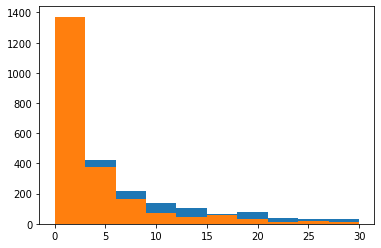

In [1265]:
in_degree = adj_matrix.sum(-1).view(-1)#.numpy()
plt.hist(in_degree, range=(0, 30))
out_degree = adj_matrix.sum(-2).view(-1)#.numpy()
plt.hist(out_degree, range=(0, 30))
# adj_matrix[:, (in_degree >= 15), :] = 0.
# adj_matrix[:, :, (in_degree >= 20)] = 0.
# adj_matrix[:, (out_degree >= 20), :] = 0.

In [1266]:
in_degree = adj_matrix.sum(-1).view(-1).numpy()
in_degree.mean()

6.212283

In [1267]:
adj_matrix.sum()

tensor(13959.)

In [1268]:
# load validation file

validation = pd.read_csv('data/validation_labels.csv', header=0, index_col=None)
validation = validation.drop(['file', 'master_crit', 'releated_crit'], axis=1)

mids = validation.mcrit_id.unique()

validation_set = {pid_to_index[key]: [] for key in mids}

for mid, rid in validation.values:
    validation_set[pid_to_index[mid]].append(pid_to_index[rid])

print(f"VALIDATION LENGTH: {len(validation_set)}")

VALIDATION LENGTH: 13


In [1269]:
unique_index = torch.unique((adj_matrix == 1).nonzero()[:, 1:2])   

index = ((adj_matrix == 1).nonzero()[:, 1:])

link_validation_set = {x.item(): adj_matrix[:, x.item(), :].squeeze(0).nonzero().view(-1).tolist() for x in unique_index}

print(f"LINK VALIDATION LENGTH: {len(link_validation_set)}")

LINK VALIDATION LENGTH: 1732


In [1152]:


tokens = {r[0]: (torch.tensor(r[1:-2973].astype('float')).float(), class_to_label[r[-1]]) for r in content.values}

In [1153]:
word_embedding_dict['rating']

tensor([-1.2129,  0.8055,  1.4610,  0.0379,  0.1806,  0.4227,  0.0555, -0.8208,
        -0.1875,  0.5199,  0.3523,  0.4450, -0.0603,  0.2949, -0.0958, -0.2393,
        -0.7951, -0.0254, -0.5349, -0.1072, -0.2695,  0.2741,  0.5659, -0.1939,
        -0.4307, -0.6783, -0.2859,  0.5997, -0.6637,  0.5548,  2.4877,  0.6128,
         1.3300, -0.5784,  0.7390, -0.6873,  0.3117, -1.1932,  0.1755, -1.9264,
        -0.0720, -0.1963,  0.4867, -0.2941, -1.4557, -0.4905,  0.2930,  1.6915,
         1.4094,  1.1178])

In [1154]:
node_tensors = torch.stack([tokens[t][0] for t in tokens]).unsqueeze(0)
# normalize
node_tensors = (node_tensors - node_tensors.mean(-2)) / (node_tensors.std(dim=-2))


# nt = torch.stack([word_embedding_dict[word] for word in content.columns[1:-3]]).repeat(2247, 1, 1).unsqueeze(0)
# mask = (node_tensors != 0.0).unsqueeze(-1).expand_as(nt).float()

# nt = nt * mask
# node_tensors = nt.sum(-2) #/ mask.sum(-2)

# normalize
# node_tensors = (node_tensors - node_tensors.mean(-2)) / (node_tensors.std(dim=-2))

class_tensors = torch.tensor([tokens[t][1] for t in tokens]).long()
node_tensors.size(), class_tensors.size() #, nt.size()

(torch.Size([1, 2247, 300]), torch.Size([2247]))

In [1155]:
node_tensors

tensor([[[ 0.3457,  0.5890,  0.6337,  ..., -0.5507,  0.2598,  0.1512],
         [ 1.1952,  0.6662,  1.0766,  ..., -0.5507,  1.5453,  1.7446],
         [-0.9031, -0.3084, -0.2685,  ..., -0.5507,  0.2598, -0.5740],
         ...,
         [ 0.0082,  0.9752,  0.9747,  ...,  0.4366, -0.5389,  1.8901],
         [ 0.4130,  1.9411,  1.3513,  ...,  0.4366,  0.8135,  1.1565],
         [-0.2966, -0.5636, -0.4330,  ..., -0.5507, -0.5389, -0.5740]]])

In [1302]:
from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(torch.arange(0, class_tensors.size(0)).numpy(), class_tensors.numpy(), 
#                                                     test_size=0.25, stratify=class_tensors.numpy(), random_state=42, shuffle=True)
# # 

X_train, X_test, y_train, y_test = train_test_split(list(link_validation_set.keys()), list(link_validation_set.values()), 
                                                    test_size=0.15, random_state=42, shuffle=True)
# 

# X_train = torch.tensor(X_train).long()
# X_test = torch.tensor(X_test).long()
# y_train = torch.tensor(y_train).long()
# y_test = torch.tensor(y_test).long()

print(f"TRAIN: {len(X_train)}\tTEST: {len(X_test)}")

# X - > Node ID
# Y -> [Node ID Links from X ID]

train_set = {k: v for (k, v) in zip(X_train, y_train)}
val_set = {k: v for (k, v) in zip(X_test, y_test)}

TRAIN: 1472	TEST: 260


In [1303]:
BATCH_SIZE = 64
log_interval = 2

# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True
# )

# train_val_loader = DataLoader(
#     train_dataset,
#     batch_size=2708,
#     shuffle=True
# )

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=2708,
#     shuffle=True
# )

# print(f"TRAIN BATCHES: {len(train_loader)}")
# print(f"VAL BATCHES: {len(val_loader)}")

In [1305]:
# train_counts = Counter()
# val_counts = Counter()

# for (x, y) in train_val_loader:
#     for i in y:
#         train_counts[i.item()] += 1
        
# for (x, y) in val_loader:
#     for i in y:
#         val_counts[i.item()] += 1
        
# print(train_counts)
# print(val_counts)

In [1764]:
EMB_DIM = 64

class GraphNetwork(Module):
    def __init__(self, n_toks):
        super().__init__()
        
        self.emb = Linear(n_toks, EMB_DIM)
        
#         node_transformer = graphnn.NodeTransformer(d_model=EMB_DIM, dim_feedforward=64, 
#                                                    nhead=8, bias=True, learned_residual=False)
#         self.node_net = graphnn.TransformerNetwork(node_transformer, n_layers=2, tie=True)

        # graph embedding network
        gal = graphnn.GraphAttentionLayer(d_model=EMB_DIM, nhead=8, dim_feedforward = EMB_DIM, 
                                          activation=F.elu,
                                          bias=True, learned_residual=False, dropout=0.1)
        self.gnet = graphnn.GraphAttentionNetwork(gal, n_hops=2, tie=False)
#         self.output = Linear(EMB_DIM, EMB_DIM)
        
    def forward(self, nodes, node_mask=None, adj_matrix=None, return_weights=True):
        out = self.emb(nodes)
#         out = F.relu(self.output(out))
        out, g_attn = self.gnet(out, adj_matrix, True)
        if return_weights:
            return out, g_attn
        return out

class PairwiseBilinear(Module):
    def __init__(self, input_size=64, bias=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = input_size
        self.linear = Linear(input_size, input_size, bias=bias)
#         pass
    
    def forward(self, embeddings):
        # pairwise dot
        norm = embeddings #/ embeddings.norm(dim=1)
#         print(self.linear(norm))
#         print(norm.transpose(-1, -2))
        dot_prod = torch.bmm(self.linear(norm), norm.transpose(-1, -2)) #/ embeddings.size(-1)
        return dot_prod

# might need to change
class DotModule(Module):
    def forward(self, embeddings):
        # pairwise dot
        norm = embeddings #/ embeddings.norm(dim=1)
#         print(norm.size())
#         print(norm.transpose(-1, -2).size())
        dot_prod = torch.bmm(norm, norm.transpose(-1, -2)) #/ embeddings.size(-1)
        return dot_prod
    
class PDistModule(Module):
    def forward(self, embeddings, p=2):
        n = embeddings.size(-2)
        d = embeddings.size(-1)
        x = embeddings.expand(n, n, d)
        y = embeddings.expand(n, n, d).transpose(-2, -3)
        dist = torch.pow(x - y, p).sum(-1).unsqueeze(0)
        return dist
        

    
class LinkPred(Module):
    def __init__(self, n_tokens, n_classes, n_nodes):
        super().__init__()
        self.gnet = GraphNetwork(n_tokens)
#         self.output = Linear(EMB_DIM, n_classes)
        self.dropout = Dropout(0.15)
#         self.dot = PairwiseBilinear()
        self.dot = DotModule()
        self.pdist = PDistModule()
#         self.output = Linear(EMB_DIM, n_nodes)
        
    def forward(self, selected_nodes, node_tensors, node_mask=None, adj_matrix=None, return_weights=False):
        mask_adj_matrix = adj_matrix
        
        if self.training:
            mask_adj_matrix = self.dropout(adj_matrix).bool().float()
            
            
        embeddings, attn = self.gnet(node_tensors, node_mask, mask_adj_matrix, True)
        
        cos_sim = self.dot(embeddings)
        
        dis_sim = None #self.pdist(embeddings, p=2)
#         cos_sim = self.output(embeddings)
        
        if return_weights:
            return cos_sim, embeddings, attn
        return cos_sim, embeddings

# if want embeddings -> run just gnet


class BaselineBilinear(Module):
    def __init__(self, n_tokens, n_classes, n_nodes):
        super().__init__()
        self.dropout = Dropout(0.15)
#         self.emb = Linear(n_tokens, 64)
        self.dot = PairwiseBilinear(n_tokens, n_tokens)
        
    def forward(self, selected_nodes, node_tensors, node_mask=None, adj_matrix=None, return_weights=False):
        
        cos_sim = self.dot(node_tensors)
        
        dis_sim = None #self.pdist(embeddings, p=2)
        
        if return_weights:
            return cos_sim, dis_sim, attn
        return cos_sim, dis_sim

In [1765]:
torch.manual_seed(10)

# model = LinkPred(node_tensors.size(-1), len(classes), node_tensors.size(-2))

model = LinkPred(node_tensors.size(-1), len(classes), node_tensors.size(-2))

print(f'NPARAM: {model.num_parameters}')

NPARAM: 69696


In [1766]:
model.eval()
with torch.no_grad():
    start = time()
    c_out, d_out, attn = model(torch.arange(0, class_tensors.size(0)), node_tensors, node_mask=None, adj_matrix=adj_matrix, return_weights=True)
    end = time()

    print(f"ELAPSED TIME: {end - start}")

ELAPSED TIME: 0.9869771003723145


In [1767]:
input1 = torch.randn(1, 128) 
input2 = input1 * -2
output = F.cosine_similarity(input1, input2)
print(output)

output = F.pairwise_distance(input1, input2)
print(output)

tensor([-1.])
tensor([37.6195])


ELAPSED TIME: 0.9511590003967285
torch.Size([1, 2247, 64])


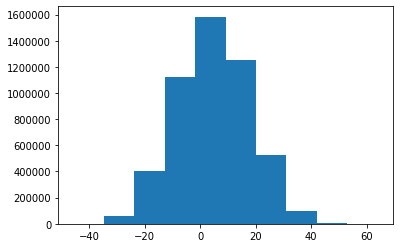

In [1768]:
%matplotlib inline

model.eval()
with torch.no_grad():
    start = time()
    c_out, d_out, attn = model(torch.arange(0, class_tensors.size(0)), node_tensors, node_mask=None, adj_matrix=adj_matrix, return_weights=True)
    end = time()
    masked_loss(c_output, train_set, adj_matrix, fake_adj_matrix)
    print(f"ELAPSED TIME: {end - start}")


print(d_out.size())

# plot distribution of dots
plt.hist(c_out.view(-1))
plt.show()

In [1769]:
c_out.size()

torch.Size([1, 2247, 2247])

In [1770]:
weights = torch.ones(node_tensors.size(1) * node_tensors.size(1))
weights[adj_matrix.view(-1) == 1] = 10.
weights.size()

torch.Size([5049009])

In [1771]:
# criterion = torch.nn.BCEWithLogitsLoss(weight=weights)
# criterion = torch.nn.BCEWithLogitsLoss(reduction='none', weight=weights)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
# criterion = torch.nn.BCEWithLogitsLoss()

lr = 0.001 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# adj_matrix_masked = torch.bernoulli(torch.full(adj_matrix.size(), 1.0)) #0.6

# fake_adj_matrix = adj_matrix * adj_matrix_masked

# adj_matrix_masked.sum(), (adj_matrix_masked != 1).sum(), adj_matrix_masked.size()

In [1772]:
fake_adj_matrix = adj_matrix.clone()
fake_adj_matrix[:, list(val_set.keys()) , : ] = 0.
fake_adj_matrix.sum()

tensor(11847.)

In [1773]:
val_set[763]

[225, 1005, 1039, 1164, 2001]

In [1774]:
adj_matrix[:, 763, 225] , fake_adj_matrix[:, 763, 255]

(tensor([1.]), tensor([0.]))

In [1775]:
# link_validation_set
# idx -> label

In [1776]:

def masked_loss(c_output, node_set, adj_matrix, fake_adj_matrix, margin=-0.25):
#     loss = criterion(output.view(-1), adj_matrix.view(-1)).reshape(*output.size()) 
#     loss = torch.zeros_like(adj_matrix)
#     loss[adj_matrix == 1.] = 100 * criterion(c_output[adj_matrix==1], adj_matrix[adj_matrix==1])
#     loss[adj_matrix == 0.] = criterion(c_output[adj_matrix==0], adj_matrix[adj_matrix==0])
#     return loss.mean()

    # only look at train nodes
    fake_adj_matrix = fake_adj_matrix[:, list(node_set.keys()), :]
    adj_matrix = adj_matrix[:, list(node_set.keys()), :]
    c_output = c_output[:, list(node_set.keys()), :]
    
    num_links = fake_adj_matrix.sum() # number of pos links
#     print(c_output.size(), d_output.size())
    
#     neg sample mask
    flat_adj_matrix = adj_matrix.view(-1)
    idx = torch.randperm(flat_adj_matrix.size(0))[:int(num_links)]
    mask = torch.zeros_like(adj_matrix).view(-1)
    mask[idx] = 1.
    mask = mask.reshape(*adj_matrix.size())
    
#     combine with adj_matrix
    mask = (mask.bool() | adj_matrix.bool()).float()
    
#     cosine loss
    
#     cosine_loss = torch.zeros_like(adj_matrix)
#     cosine_loss[adj_matrix == 1.] = (1 - c_output[adj_matrix==1.])
#     cosine_loss[adj_matrix == 0.] = F.relu(c_output[adj_matrix==0.] + 0.3)
    
    loss = criterion(c_output[mask == 1.].view(-1), adj_matrix[mask == 1.].view(-1))
#     hinge loss
#     hinge_loss = torch.zeros_like(adj_matrix)
#     hinge_loss[adj_matrix == 1.] = d_output[adj_matrix==1.]
#     hinge_loss[adj_matrix == 0.] = F.relu(5. - d_output[adj_matrix==0.])
    
    
    
    diag_mask = (torch.eye(*adj_matrix.squeeze(0).size()).unsqueeze(0) != 1.).float()
    
#     loss = hinge_loss * mask
#     loss = cosine_loss * mask
    # dont need masks b/c already reduce the set above, and since self-ref not in adj_matrix, we dont take loss
    loss = loss #* diag_mask
    loss = loss.sum() / (2 * num_links) #/ (10 * num_links) #/ (mask * diag_mask).sum()
    return loss

In [1777]:
from sklearn.metrics import average_precision_score, roc_auc_score

BATCHES = 32

# TRAIN
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time()
    
    for batch in tqdm(range(BATCHES)):
        optimizer.zero_grad()
        
        c_output, d_output = model(node_tensors, node_tensors, 
                       node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)
        
        # sample?, zero out diagonal?
        loss = masked_loss(c_output, train_set, adj_matrix, fake_adj_matrix)
#         loss = criterion(output.view(-1), adj_matrix.view(-1)).reshape(*output.size()) 

        loss.backward()
        print(torch.nn.utils.clip_grad_norm_(model.parameters(), 2.5))
        optimizer.step()

        total_loss += loss.item()
        
        if batch % log_interval == 0 and batch >= 0:

            acc = ((output > 0) == adj_matrix)[adj_matrix_masked == 1.].float().mean()
            cur_loss = total_loss / log_interval
            elapsed = time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.4f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | acc {:.2f} |'.format(
                    epoch, batch, BATCHES, lr,
                    elapsed * 1000 / log_interval,
                    cur_loss, acc))
            total_loss = 0
            start_time = time()

def evaluate(node_set):
    model.eval() # Turn on the evaluation mode
    total_loss, acc = 0., 0.

    with torch.no_grad():
        
        for batch in tqdm(range(BATCHES)):
            
            c_output, d_output = model(node_tensors, node_tensors, 
                                   node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)
            
#             loss = criterion(output.view(-1), adj_matrix.view(-1)).reshape(*output.size()) 
            loss = masked_loss(c_output, node_set, adj_matrix, fake_adj_matrix)

            total_loss += loss
            auc_prc = 0.#average_precision_score(adj_matrix[adj_matrix_masked == 1.].view(-1), torch.sigmoid(output[adj_matrix_masked == 1.].view(-1)))
            roc = 0.#roc_auc_score(adj_matrix[adj_matrix_masked == 1.].view(-1), torch.sigmoid(output[adj_matrix_masked == 1.].view(-1)))
            
            acc = ((output > 0) == adj_matrix)[adj_matrix_masked == 1.].float().mean()
            
            
    return total_loss / (2*adj_matrix.sum()), acc, auc_prc, roc,


In [1778]:
best_val_loss = 0.0
best_model = None
print(best_val_loss)

0.0


In [1779]:
K = 20
best_val_loss

0.0

In [1780]:
epochs = 60 # The number of epochs


# torch.autograd.set_detect_anomaly(True)

for epoch in range(1, epochs + 1):

    epoch_start_time = time()
    train()
#     train_loss, train_acc, train_auc, train_roc = evaluate(train_val_loader)
#     val_loss, val_acc, val_auc, val_roc = evaluate(val_loader)
    
    print('-' * 103)
    print('| end of epoch {:3d} | time: {:5.2f}s |'.format(epoch, (time() - epoch_start_time)))
#     print('| train loss {:5.2f} | train acc {:.2f} | train auc {:.2f} | train roc {:.2f} |'.format(train_loss, train_acc, train_auc, train_roc))
#     print('| val   loss {:5.2f} | val   acc {:.2f} | val   auc {:.2f} | val   roc {:.2f} |'.format(val_loss, val_acc, val_auc, val_roc))
    
    model.eval()
    with torch.no_grad():
        out, embeddding = model(node_tensors, node_tensors, 
                       node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)
    means, results = validate_run(embeddding, train_set, k=K)
    print('^^ Train')
    
    
    model.eval()
    with torch.no_grad():
        out, embeddding = model(node_tensors, node_tensors, 
                       node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)
    
    means, results = validate_run(embeddding, val_set, k=K)
    print('^^ Val')
    print('-' * 103)

    if means['r@kd'] > best_val_loss:
        best_val_loss = means['r@kd']
        best_model = model
        torch.save(model, 'baseline_graph_wout_res.pkl')

#     scheduler.step()

6.0309612310699405
| epoch   1 |     0/   32 batches | lr 0.0010 | ms/batch 1223.70 | loss  2.33 | acc 0.00 |
5.121871828367931
4.132578163518972
| epoch   1 |     2/   32 batches | lr 0.0010 | ms/batch 3426.11 | loss  4.32 | acc 0.00 |
4.180242521064459
3.960497011327817
| epoch   1 |     4/   32 batches | lr 0.0010 | ms/batch 2031.55 | loss  4.01 | acc 0.00 |
3.626949707261828
3.491725184770704
| epoch   1 |     6/   32 batches | lr 0.0010 | ms/batch 2026.75 | loss  3.83 | acc 0.00 |
3.3416449928087464
3.3751034315568234
| epoch   1 |     8/   32 batches | lr 0.0010 | ms/batch 1901.36 | loss  3.61 | acc 0.00 |
3.13500446333784
2.928481364106373
| epoch   1 |    10/   32 batches | lr 0.0010 | ms/batch 1897.55 | loss  3.49 | acc 0.00 |
2.9698707599375607
2.972300595281065
| epoch   1 |    12/   32 batches | lr 0.0010 | ms/batch 1898.72 | loss  3.35 | acc 0.00 |
2.9531126547919815
2.7192461595253943
| epoch   1 |    14/   32 batches | lr 0.0010 | ms/batch 1963.82 | loss  3.25 | acc 0.00

RESULT
MSD:   9.853798013666403
CS:    0.17405501304997612
P@KD:  0.07476222826086797
R@KD:  0.2638990818278171
P@KC:  0.07445652173912883
R@KC:  0.263496490575919
^^ Train


RESULT
MSD:   10.047828522095314
CS:    0.14021627686810323
P@KD:  0.07173076923076951
R@KD:  0.2579861308533232
P@KC:  0.07153846153846181
R@KC:  0.25803632104774415
^^ Val
-------------------------------------------------------------------------------------------------------


2.198072864954857
| epoch   2 |     0/   32 batches | lr 0.0010 | ms/batch 1058.30 | loss  1.31 | acc 0.00 |
2.291226090518161
2.188695058630408
| epoch   2 |     2/   32 batches | lr 0.0010 | ms/batch 1989.33 | loss  2.58 | acc 0.00 |
2.1318316325361493
2.1516143936625762
| epoch   2 |     4/   32 batches | lr 0.0010 | ms/batch 1945.91 | loss  2.54 | acc 0.00 |
2.1278515746582873
2.306080496308966
| epoch   2 |     6/   32 batches | lr 0.0010 | ms/batch 1963.12 | loss  2.49 | acc 0.00 |
2.078501397465493
1.8966742670894203
| epoch   2 |     8/   32 batches | lr 0.0010 | ms/batch 1970.76 | loss  2.42 | acc 0.00 |
2.106360318073568
2.045996907716157
| epoch   2 |    10/   32 batches | lr 0.0010 | ms/batch 1963.92 | loss  2.46 | acc 0.00 |
2.011062573175359
1.9667883880231722
| epoch   2 |    12/   32 batches | lr 0.0010 | ms/batch 1959.10 | loss  2.34 | acc 0.00 |
1.8861129821507385
1.9313327170536787
| epoch   2 |    14/   32 batches | lr 0.0010 | ms/batch 1970.75 | loss  2.37 | acc 0.

RESULT
MSD:   9.248839489467766
CS:    0.221912430603128
P@KD:  0.0912024456521727
R@KD:  0.28913113891489817
P@KC:  0.09062499999999873
R@KC:  0.2882352193893368
^^ Train


RESULT
MSD:   9.5599061525785
CS:    0.16811189895245032
P@KD:  0.08596153846153874
R@KD:  0.27503871653581313
P@KC:  0.08480769230769261
R@KC:  0.2732875495685615
^^ Val
-------------------------------------------------------------------------------------------------------


1.7193202084459047
| epoch   3 |     0/   32 batches | lr 0.0010 | ms/batch 1002.74 | loss  1.08 | acc 0.00 |
1.805913619374595
1.6778118457629205
| epoch   3 |     2/   32 batches | lr 0.0010 | ms/batch 1923.58 | loss  2.13 | acc 0.00 |
1.7138098491521656
1.714878401213946
| epoch   3 |     4/   32 batches | lr 0.0010 | ms/batch 1927.66 | loss  2.12 | acc 0.00 |
1.7249845461590099
1.7374859278002608
| epoch   3 |     6/   32 batches | lr 0.0010 | ms/batch 1917.83 | loss  2.05 | acc 0.00 |
1.8318670962394537
1.805819736737338
| epoch   3 |     8/   32 batches | lr 0.0010 | ms/batch 1933.25 | loss  2.07 | acc 0.00 |
1.8083513124110588
1.6955341245599302
| epoch   3 |    10/   32 batches | lr 0.0010 | ms/batch 1905.39 | loss  2.04 | acc 0.00 |
1.6972845133663963
1.777197929566853
| epoch   3 |    12/   32 batches | lr 0.0010 | ms/batch 1928.95 | loss  2.02 | acc 0.00 |
1.727683763481469
1.690189162785271
| epoch   3 |    14/   32 batches | lr 0.0010 | ms/batch 1912.19 | loss  2.02 | acc 

RESULT
MSD:   8.852129640462605
CS:    0.24075917788281023
P@KD:  0.10037364130434737
R@KD:  0.30696767994145385
P@KC:  0.09881114130434736
R@KC:  0.3041155805520142
^^ Train


RESULT
MSD:   9.191808346601633
CS:    0.18066371108154552
P@KD:  0.0923076923076926
R@KD:  0.2907246538874405
P@KC:  0.09096153846153875
R@KC:  0.2889732002129099
^^ Val
-------------------------------------------------------------------------------------------------------


1.6016390443747863
| epoch   4 |     0/   32 batches | lr 0.0010 | ms/batch 1107.02 | loss  0.95 | acc 0.00 |
1.5959767761206145
1.5334873378076694
| epoch   4 |     2/   32 batches | lr 0.0010 | ms/batch 1982.17 | loss  1.87 | acc 0.00 |
1.5606082303540014
1.5392867185051602
| epoch   4 |     4/   32 batches | lr 0.0010 | ms/batch 1915.58 | loss  1.88 | acc 0.00 |
1.5838313949694478
1.5224301849915156
| epoch   4 |     6/   32 batches | lr 0.0010 | ms/batch 1921.37 | loss  1.84 | acc 0.00 |
1.5777618401084328
1.5130467608981184
| epoch   4 |     8/   32 batches | lr 0.0010 | ms/batch 1899.42 | loss  1.83 | acc 0.00 |
1.5671834166413428
1.5300613151910218
| epoch   4 |    10/   32 batches | lr 0.0010 | ms/batch 2003.48 | loss  1.83 | acc 0.00 |
1.4865296955948903
1.5404004156984223
| epoch   4 |    12/   32 batches | lr 0.0010 | ms/batch 2021.25 | loss  1.79 | acc 0.00 |
1.5159165936335326
1.5009877100296383
| epoch   4 |    14/   32 batches | lr 0.0010 | ms/batch 2105.69 | loss  1.80 

RESULT
MSD:   8.515146781568943
CS:    0.25201882161032385
P@KD:  0.10760869565217386
R@KD:  0.3255578813994035
P@KC:  0.10594429347826073
R@KC:  0.3209444689829399
^^ Train


RESULT
MSD:   8.832719553433932
CS:    0.19425157139328522
P@KD:  0.09980769230769258
R@KD:  0.3083937558663821
P@KC:  0.09865384615384644
R@KC:  0.3052891590320693
^^ Val
-------------------------------------------------------------------------------------------------------


1.3776142496059733
| epoch   5 |     0/   32 batches | lr 0.0010 | ms/batch 1028.55 | loss  0.83 | acc 0.00 |
1.4704852561951554
1.4148426575221054
| epoch   5 |     2/   32 batches | lr 0.0010 | ms/batch 1988.84 | loss  1.71 | acc 0.00 |
1.375448059931984
1.4131272366247623
| epoch   5 |     4/   32 batches | lr 0.0010 | ms/batch 2014.80 | loss  1.68 | acc 0.00 |
1.2902028658957725
1.4043590025186241
| epoch   5 |     6/   32 batches | lr 0.0010 | ms/batch 2042.69 | loss  1.65 | acc 0.00 |
1.3282873619284699
1.3449087965520636
| epoch   5 |     8/   32 batches | lr 0.0010 | ms/batch 2030.46 | loss  1.65 | acc 0.00 |
1.4359153130678586
1.3236722353147268
| epoch   5 |    10/   32 batches | lr 0.0010 | ms/batch 1991.62 | loss  1.64 | acc 0.00 |
1.3158824107600962
1.3225087866987502
| epoch   5 |    12/   32 batches | lr 0.0010 | ms/batch 2054.28 | loss  1.65 | acc 0.00 |
1.4676121993984401
1.2477089256270906
| epoch   5 |    14/   32 batches | lr 0.0010 | ms/batch 2034.02 | loss  1.62 |

RESULT
MSD:   8.1793205064276
CS:    0.26374353412337886
P@KD:  0.11542119565217407
R@KD:  0.3406699525461629
P@KC:  0.11355298913043485
R@KC:  0.3366737171121613
^^ Train


RESULT
MSD:   8.531255943958575
CS:    0.1988805876328395
P@KD:  0.09980769230769264
R@KD:  0.30240298893854406
P@KC:  0.09846153846153878
R@KC:  0.3004508545618407
^^ Val
-------------------------------------------------------------------------------------------------------


1.2459476451400087
| epoch   6 |     0/   32 batches | lr 0.0010 | ms/batch 999.18 | loss  0.77 | acc 0.00 |
1.3043076152663768
1.346355915060474
| epoch   6 |     2/   32 batches | lr 0.0010 | ms/batch 1963.32 | loss  1.54 | acc 0.00 |
1.3185802722215942
1.2219875810132985
| epoch   6 |     4/   32 batches | lr 0.0010 | ms/batch 1971.67 | loss  1.51 | acc 0.00 |
1.2600552344659741
1.2377245335927745
| epoch   6 |     6/   32 batches | lr 0.0010 | ms/batch 1927.97 | loss  1.52 | acc 0.00 |
1.2347587294772004
1.2550635411783357
| epoch   6 |     8/   32 batches | lr 0.0010 | ms/batch 1936.64 | loss  1.54 | acc 0.00 |
1.2645807787988652
1.192288803898448
| epoch   6 |    10/   32 batches | lr 0.0010 | ms/batch 1926.45 | loss  1.50 | acc 0.00 |
1.1890477559555543
1.1786388848210376
| epoch   6 |    12/   32 batches | lr 0.0010 | ms/batch 1970.57 | loss  1.50 | acc 0.00 |
1.1778142690536848
1.1634445277812
| epoch   6 |    14/   32 batches | lr 0.0010 | ms/batch 1968.61 | loss  1.51 | acc 

RESULT
MSD:   7.868714471226153
CS:    0.27206931939951534
P@KD:  0.1217730978260873
R@KD:  0.3528140249926458
P@KC:  0.11942934782608713
R@KC:  0.34766674559577737
^^ Train


RESULT
MSD:   8.23829000729781
CS:    0.20218665449233064
P@KD:  0.10865384615384648
R@KD:  0.3200594769448528
P@KC:  0.10538461538461572
R@KC:  0.3133661725334621
^^ Val
-------------------------------------------------------------------------------------------------------


1.2173259760472286
| epoch   7 |     0/   32 batches | lr 0.0010 | ms/batch 1065.09 | loss  0.71 | acc 0.00 |
1.162436135995405
1.212683475992645
| epoch   7 |     2/   32 batches | lr 0.0010 | ms/batch 2009.52 | loss  1.43 | acc 0.00 |
1.1619715709936749
1.1434737568574351
| epoch   7 |     4/   32 batches | lr 0.0010 | ms/batch 2049.22 | loss  1.44 | acc 0.00 |
1.1861544785899287
1.1385797490938485
| epoch   7 |     6/   32 batches | lr 0.0010 | ms/batch 1926.93 | loss  1.40 | acc 0.00 |
1.1770523697263366
1.140997153520838
| epoch   7 |     8/   32 batches | lr 0.0010 | ms/batch 1940.86 | loss  1.41 | acc 0.00 |
1.1535609628868535
1.1317541657712704
| epoch   7 |    10/   32 batches | lr 0.0010 | ms/batch 2007.85 | loss  1.41 | acc 0.00 |
1.090180517971674
1.1220967499319765
| epoch   7 |    12/   32 batches | lr 0.0010 | ms/batch 1997.34 | loss  1.39 | acc 0.00 |
1.1297677968835176
1.1789038050009413
| epoch   7 |    14/   32 batches | lr 0.0010 | ms/batch 1964.75 | loss  1.38 | ac

RESULT
MSD:   7.573994277612023
CS:    0.2784870355537904
P@KD:  0.12374320652173948
R@KD:  0.3607100049980681
P@KC:  0.1206182065217393
R@KC:  0.3536856801707305
^^ Train


RESULT
MSD:   7.943190226188073
CS:    0.20653256666309272
P@KD:  0.11076923076923105
R@KD:  0.33334150490647335
P@KC:  0.10750000000000029
R@KC:  0.3225099113659367
^^ Val
-------------------------------------------------------------------------------------------------------


1.0584946134726998
| epoch   8 |     0/   32 batches | lr 0.0010 | ms/batch 1092.07 | loss  0.65 | acc 0.00 |
1.150000673673844
1.0514106224954975
| epoch   8 |     2/   32 batches | lr 0.0010 | ms/batch 2030.48 | loss  1.32 | acc 0.00 |
1.0527172205028226
1.0754807936255433
| epoch   8 |     4/   32 batches | lr 0.0010 | ms/batch 2022.50 | loss  1.30 | acc 0.00 |
1.0619457622226969
1.0866885780496136
| epoch   8 |     6/   32 batches | lr 0.0010 | ms/batch 2107.88 | loss  1.31 | acc 0.00 |
1.0127779703819528
1.0697791254669677
| epoch   8 |     8/   32 batches | lr 0.0010 | ms/batch 2087.87 | loss  1.31 | acc 0.00 |
1.1150103667725448
1.0150386760255385
| epoch   8 |    10/   32 batches | lr 0.0010 | ms/batch 2081.16 | loss  1.30 | acc 0.00 |
1.0501704841490693
1.0323845191355732
| epoch   8 |    12/   32 batches | lr 0.0010 | ms/batch 2079.48 | loss  1.30 | acc 0.00 |
1.0547132391281668
0.9849035209672763
| epoch   8 |    14/   32 batches | lr 0.0010 | ms/batch 2040.94 | loss  1.26 |

RESULT
MSD:   7.274605023796144
CS:    0.2852673594119867
P@KD:  0.12961956521739174
R@KD:  0.3726226682993062
P@KC:  0.12605298913043528
R@KC:  0.3634211716853518
^^ Train


RESULT
MSD:   7.65479493691371
CS:    0.2097706581694253
P@KD:  0.10884615384615416
R@KD:  0.3229796768072891
P@KC:  0.10576923076923112
R@KC:  0.3172797723542299
^^ Val
-------------------------------------------------------------------------------------------------------


0.9621766065219405
| epoch   9 |     0/   32 batches | lr 0.0010 | ms/batch 1059.89 | loss  0.60 | acc 0.00 |
1.0013915834810214
0.9751408972338994
| epoch   9 |     2/   32 batches | lr 0.0010 | ms/batch 1969.33 | loss  1.22 | acc 0.00 |
0.940960619206855
1.0045408096198705
| epoch   9 |     4/   32 batches | lr 0.0010 | ms/batch 1959.31 | loss  1.22 | acc 0.00 |
1.0244765313800408
1.0050239226806208
| epoch   9 |     6/   32 batches | lr 0.0010 | ms/batch 1987.65 | loss  1.22 | acc 0.00 |
1.0269937222790284
0.9780316281259757
| epoch   9 |     8/   32 batches | lr 0.0010 | ms/batch 1972.21 | loss  1.18 | acc 0.00 |
0.9717636194276176
0.9508776050452467
| epoch   9 |    10/   32 batches | lr 0.0010 | ms/batch 1995.47 | loss  1.19 | acc 0.00 |
0.942900056176421
0.977739101743759
| epoch   9 |    12/   32 batches | lr 0.0010 | ms/batch 2016.46 | loss  1.20 | acc 0.00 |
0.9268220906530223
0.912890871867064
| epoch   9 |    14/   32 batches | lr 0.0010 | ms/batch 2003.30 | loss  1.19 | ac

RESULT
MSD:   6.979859624219977
CS:    0.2915538049384612
P@KD:  0.1352921195652178
R@KD:  0.3848708791681672
P@KC:  0.1300951086956526
R@KC:  0.37134919904968217
^^ Train


RESULT
MSD:   7.342821449499864
CS:    0.21832469144853978
P@KD:  0.11038461538461565
R@KD:  0.3262608949363206
P@KC:  0.1086538461538464
R@KC:  0.32400566092889144
^^ Val
-------------------------------------------------------------------------------------------------------


0.923641788954945
| epoch  10 |     0/   32 batches | lr 0.0010 | ms/batch 987.70 | loss  0.56 | acc 0.00 |
0.9264940375664366
0.9014967686519987
| epoch  10 |     2/   32 batches | lr 0.0010 | ms/batch 1915.51 | loss  1.13 | acc 0.00 |
0.8967644271036315
0.9070880582475664
| epoch  10 |     4/   32 batches | lr 0.0010 | ms/batch 1907.93 | loss  1.14 | acc 0.00 |
0.9039315851551296
0.8585120229756126
| epoch  10 |     6/   32 batches | lr 0.0010 | ms/batch 1914.30 | loss  1.13 | acc 0.00 |
0.8763064939275573
0.8544582996239515
| epoch  10 |     8/   32 batches | lr 0.0010 | ms/batch 1921.02 | loss  1.12 | acc 0.00 |
0.9208565804170094
0.8617434292050811
| epoch  10 |    10/   32 batches | lr 0.0010 | ms/batch 1919.89 | loss  1.11 | acc 0.00 |
0.9340718024353266
0.8382164049714883
| epoch  10 |    12/   32 batches | lr 0.0010 | ms/batch 1929.68 | loss  1.13 | acc 0.00 |
0.895497331421829
0.8533898818264798
| epoch  10 |    14/   32 batches | lr 0.0010 | ms/batch 1918.81 | loss  1.12 | a

RESULT
MSD:   6.6739331731653735
CS:    0.2993161928028238
P@KD:  0.13967391304347873
R@KD:  0.3996252907478905
P@KC:  0.13454483695652222
R@KC:  0.38413667452237305
^^ Train


RESULT
MSD:   7.040991948201106
CS:    0.22282621499806948
P@KD:  0.1144230769230772
R@KD:  0.33173129217687375
P@KC:  0.11038461538461565
R@KC:  0.32535674027560524
^^ Val
-------------------------------------------------------------------------------------------------------


0.812659309319662
| epoch  11 |     0/   32 batches | lr 0.0010 | ms/batch 1020.98 | loss  0.53 | acc 0.00 |
0.8369717769664602
0.8327250174131252
| epoch  11 |     2/   32 batches | lr 0.0010 | ms/batch 2003.34 | loss  1.06 | acc 0.00 |
0.8399497856451325
0.8107044973476797
| epoch  11 |     4/   32 batches | lr 0.0010 | ms/batch 1976.63 | loss  1.05 | acc 0.00 |
0.8617187448221584
0.8224890843755214
| epoch  11 |     6/   32 batches | lr 0.0010 | ms/batch 1988.22 | loss  1.05 | acc 0.00 |
0.7760211656444254
0.8068606560168882
| epoch  11 |     8/   32 batches | lr 0.0010 | ms/batch 2034.73 | loss  1.04 | acc 0.00 |
0.7975440752475117
0.7843155214592905
| epoch  11 |    10/   32 batches | lr 0.0010 | ms/batch 2077.34 | loss  1.04 | acc 0.00 |
0.8242820727863107
0.8105009823190436
| epoch  11 |    12/   32 batches | lr 0.0010 | ms/batch 2030.48 | loss  1.05 | acc 0.00 |
0.842072690080223
0.806518837894727
| epoch  11 |    14/   32 batches | lr 0.0010 | ms/batch 1971.61 | loss  1.03 | a

RESULT
MSD:   6.383480537844741
CS:    0.3045284844326449
P@KD:  0.14436141304347871
R@KD:  0.41332846589267114
P@KC:  0.1374660326086959
R@KC:  0.3928449507332656
^^ Train


RESULT
MSD:   6.75577179651994
CS:    0.22546911163640637
P@KD:  0.11711538461538493
R@KD:  0.34509809693204185
P@KC:  0.11096153846153875
R@KC:  0.3257496772136919
^^ Val
-------------------------------------------------------------------------------------------------------


0.7356504093576253
| epoch  12 |     0/   32 batches | lr 0.0010 | ms/batch 1084.67 | loss  0.49 | acc 0.00 |
0.7722361805452416
0.7548828628632169
| epoch  12 |     2/   32 batches | lr 0.0010 | ms/batch 1982.47 | loss  0.99 | acc 0.00 |
0.7302999270821983
0.7413753887152031
| epoch  12 |     4/   32 batches | lr 0.0010 | ms/batch 2013.65 | loss  0.97 | acc 0.00 |
0.7679993495160978
0.7407716146189823
| epoch  12 |     6/   32 batches | lr 0.0010 | ms/batch 2019.93 | loss  0.98 | acc 0.00 |
0.7763436836304797
0.7666818418353051
| epoch  12 |     8/   32 batches | lr 0.0010 | ms/batch 2001.18 | loss  0.99 | acc 0.00 |
0.7519891245307151
0.7580163038921576
| epoch  12 |    10/   32 batches | lr 0.0010 | ms/batch 1999.14 | loss  0.97 | acc 0.00 |
0.7250442705866738
0.7612211258534343
| epoch  12 |    12/   32 batches | lr 0.0010 | ms/batch 1907.94 | loss  0.96 | acc 0.00 |
0.7923884763836093
0.7520866918697384
| epoch  12 |    14/   32 batches | lr 0.0010 | ms/batch 2018.93 | loss  0.98 

RESULT
MSD:   6.088690772490657
CS:    0.3088978043560137
P@KD:  0.1480978260869572
R@KD:  0.42357793190950327
P@KC:  0.1398437500000003
R@KC:  0.4000370968290711
^^ Train


RESULT
MSD:   6.468555558644808
CS:    0.22587415322576326
P@KD:  0.1150000000000003
R@KD:  0.3382046266088906
P@KC:  0.10903846153846186
R@KC:  0.32280388648403713
^^ Val
-------------------------------------------------------------------------------------------------------


0.7388812659147503
| epoch  13 |     0/   32 batches | lr 0.0010 | ms/batch 997.20 | loss  0.46 | acc 0.00 |
0.6951869004487277
0.7192837541107613
| epoch  13 |     2/   32 batches | lr 0.0010 | ms/batch 1944.50 | loss  0.92 | acc 0.00 |
0.6706782083061945
0.679338213018564
| epoch  13 |     4/   32 batches | lr 0.0010 | ms/batch 1989.09 | loss  0.93 | acc 0.00 |
0.6986186048117158
0.7073888407587574
| epoch  13 |     6/   32 batches | lr 0.0010 | ms/batch 1928.11 | loss  0.91 | acc 0.00 |
0.6656549102837503
0.6844212781590552
| epoch  13 |     8/   32 batches | lr 0.0010 | ms/batch 1951.17 | loss  0.92 | acc 0.00 |
0.6748072312944474
0.664643280048701
| epoch  13 |    10/   32 batches | lr 0.0010 | ms/batch 1993.71 | loss  0.89 | acc 0.00 |
0.6536012739852834
0.6779718617349537
| epoch  13 |    12/   32 batches | lr 0.0010 | ms/batch 1948.57 | loss  0.91 | acc 0.00 |
0.6943302800089608
0.6856243553830312
| epoch  13 |    14/   32 batches | lr 0.0010 | ms/batch 1936.76 | loss  0.89 | a

RESULT
MSD:   5.751380485037099
CS:    0.31804957870253536
P@KD:  0.15343070652173954
R@KD:  0.43442341800014306
P@KC:  0.142900815217392
R@KC:  0.40490102818547435
^^ Train


RESULT
MSD:   6.123229362414434
CS:    0.2352731015954095
P@KD:  0.12057692307692337
R@KD:  0.35326257695028307
P@KC:  0.11307692307692337
R@KC:  0.3328921888953701
^^ Val
-------------------------------------------------------------------------------------------------------


0.6568412941299481
| epoch  14 |     0/   32 batches | lr 0.0010 | ms/batch 1084.32 | loss  0.43 | acc 0.00 |
0.6371427912962881
0.6275528422149022
| epoch  14 |     2/   32 batches | lr 0.0010 | ms/batch 1969.63 | loss  0.85 | acc 0.00 |
0.6453254756101569
0.6285768585619084
| epoch  14 |     4/   32 batches | lr 0.0010 | ms/batch 1976.89 | loss  0.86 | acc 0.00 |
0.6144335502350432
0.6297866979554011
| epoch  14 |     6/   32 batches | lr 0.0010 | ms/batch 1930.47 | loss  0.85 | acc 0.00 |
0.6177431931306455
0.6238128843577239
| epoch  14 |     8/   32 batches | lr 0.0010 | ms/batch 1963.86 | loss  0.85 | acc 0.00 |
0.5829804639208768
0.6133490093811828
| epoch  14 |    10/   32 batches | lr 0.0010 | ms/batch 1982.17 | loss  0.84 | acc 0.00 |
0.6048657436453283
0.6117688826156539
| epoch  14 |    12/   32 batches | lr 0.0010 | ms/batch 2034.02 | loss  0.84 | acc 0.00 |
0.5841297601755507
0.5766916084727035
| epoch  14 |    14/   32 batches | lr 0.0010 | ms/batch 1998.00 | loss  0.83 

RESULT
MSD:   5.380212392172088
CS:    0.3291210790617776
P@KD:  0.15754076086956562
R@KD:  0.44728155159759514
P@KC:  0.14707880434782664
R@KC:  0.41709870355611955
^^ Train


RESULT
MSD:   5.759522540752704
CS:    0.24338888416442878
P@KD:  0.12038461538461565
R@KD:  0.3557474185062019
P@KC:  0.11307692307692335
R@KC:  0.3379234439644405
^^ Val
-------------------------------------------------------------------------------------------------------


0.5825283290485118
| epoch  15 |     0/   32 batches | lr 0.0010 | ms/batch 1076.99 | loss  0.40 | acc 0.00 |
0.5526052139451412
0.5671544834417731
| epoch  15 |     2/   32 batches | lr 0.0010 | ms/batch 2028.72 | loss  0.79 | acc 0.00 |
0.5398109562603407
0.5753295665751
| epoch  15 |     4/   32 batches | lr 0.0010 | ms/batch 2034.48 | loss  0.79 | acc 0.00 |
0.5831864428591977
0.5431263277334148
| epoch  15 |     6/   32 batches | lr 0.0010 | ms/batch 2116.09 | loss  0.79 | acc 0.00 |
0.5666526978823005
0.5664550729789688
| epoch  15 |     8/   32 batches | lr 0.0010 | ms/batch 2004.43 | loss  0.79 | acc 0.00 |
0.5569534292594578
0.5562503985430183
| epoch  15 |    10/   32 batches | lr 0.0010 | ms/batch 1977.67 | loss  0.79 | acc 0.00 |
0.5658962731890802
0.5537946200739334
| epoch  15 |    12/   32 batches | lr 0.0010 | ms/batch 2029.79 | loss  0.78 | acc 0.00 |
0.5537549575977326
0.5252900328763567
| epoch  15 |    14/   32 batches | lr 0.0010 | ms/batch 2122.21 | loss  0.76 | a

RESULT
MSD:   5.0136371539986655
CS:    0.3379967046441142
P@KD:  0.16090353260869608
R@KD:  0.45439118485989105
P@KC:  0.15074728260869635
R@KC:  0.4245066479574828
^^ Train


RESULT
MSD:   5.394822703875028
CS:    0.24990682190355773
P@KD:  0.12346153846153879
R@KD:  0.36342028137541327
P@KC:  0.11519230769230801
R@KC:  0.3442366929873368
^^ Val
-------------------------------------------------------------------------------------------------------


0.5409775688255926
| epoch  16 |     0/   32 batches | lr 0.0010 | ms/batch 1044.79 | loss  0.37 | acc 0.00 |
0.523245413982622
0.5168028672290221
| epoch  16 |     2/   32 batches | lr 0.0010 | ms/batch 1941.87 | loss  0.75 | acc 0.00 |
0.5037719111890807
0.5233007239926815
| epoch  16 |     4/   32 batches | lr 0.0010 | ms/batch 1963.77 | loss  0.73 | acc 0.00 |
0.5247904302033702
0.508247213097478
| epoch  16 |     6/   32 batches | lr 0.0010 | ms/batch 1945.69 | loss  0.73 | acc 0.00 |
0.5043199186013766
0.5101097460292651
| epoch  16 |     8/   32 batches | lr 0.0010 | ms/batch 1984.98 | loss  0.73 | acc 0.00 |
0.5096967001399659
0.5029283786692202
| epoch  16 |    10/   32 batches | lr 0.0010 | ms/batch 1912.88 | loss  0.73 | acc 0.00 |
0.5029413560980337
0.5055353725349803
| epoch  16 |    12/   32 batches | lr 0.0010 | ms/batch 1953.39 | loss  0.73 | acc 0.00 |
0.4997551861703812
0.5077837928833714
| epoch  16 |    14/   32 batches | lr 0.0010 | ms/batch 1980.18 | loss  0.72 | 

RESULT
MSD:   4.5743261254999945
CS:    0.35143280080734735
P@KD:  0.16494565217391366
R@KD:  0.46491256606951564
P@KC:  0.15438179347826167
R@KC:  0.4335236005430936
^^ Train


RESULT
MSD:   4.951127254045927
CS:    0.2615329734264658
P@KD:  0.13115384615384643
R@KD:  0.3779502694706653
P@KC:  0.11961538461538491
R@KC:  0.3504254367149005
^^ Val
-------------------------------------------------------------------------------------------------------


0.4506868328517459
| epoch  17 |     0/   32 batches | lr 0.0010 | ms/batch 1061.06 | loss  0.34 | acc 0.00 |
0.47141482337330737
0.4695062531005311
| epoch  17 |     2/   32 batches | lr 0.0010 | ms/batch 2054.61 | loss  0.68 | acc 0.00 |
0.4485315712777611
0.4642822304668191
| epoch  17 |     4/   32 batches | lr 0.0010 | ms/batch 1967.01 | loss  0.67 | acc 0.00 |
0.4502963015642713
0.4381389711657896
| epoch  17 |     6/   32 batches | lr 0.0010 | ms/batch 2035.14 | loss  0.68 | acc 0.00 |
0.46592051665585843
0.4522440260657156
| epoch  17 |     8/   32 batches | lr 0.0010 | ms/batch 2051.76 | loss  0.68 | acc 0.00 |
0.4580304496133516
0.43421202218954114
| epoch  17 |    10/   32 batches | lr 0.0010 | ms/batch 1993.79 | loss  0.67 | acc 0.00 |
0.4377992607709414
0.4370863751358206
| epoch  17 |    12/   32 batches | lr 0.0010 | ms/batch 1969.58 | loss  0.66 | acc 0.00 |
0.46949994671291134
0.44021618806988827
| epoch  17 |    14/   32 batches | lr 0.0010 | ms/batch 1907.29 | loss  

RESULT
MSD:   4.056705593576898
CS:    0.37115179861480696
P@KD:  0.163722826086957
R@KD:  0.4673013181141585
P@KC:  0.1558423913043483
R@KC:  0.4423330516930629
^^ Train


RESULT
MSD:   4.425018792886
CS:    0.28137108102673664
P@KD:  0.12942307692307714
R@KD:  0.37520977576658265
P@KC:  0.12134615384615413
R@KC:  0.35304951791047817
^^ Val
-------------------------------------------------------------------------------------------------------


0.3993781557682765
| epoch  18 |     0/   32 batches | lr 0.0010 | ms/batch 1020.04 | loss  0.31 | acc 0.00 |
0.3863512701177784
0.4061845233011141
| epoch  18 |     2/   32 batches | lr 0.0010 | ms/batch 2044.17 | loss  0.63 | acc 0.00 |
0.3981634684742574
0.39561693552249494
| epoch  18 |     4/   32 batches | lr 0.0010 | ms/batch 2062.44 | loss  0.62 | acc 0.00 |
0.41838114135842946
0.41554069958620293
| epoch  18 |     6/   32 batches | lr 0.0010 | ms/batch 2061.91 | loss  0.63 | acc 0.00 |
0.3848430318345246
0.40877598713849733
| epoch  18 |     8/   32 batches | lr 0.0010 | ms/batch 1919.99 | loss  0.62 | acc 0.00 |
0.38679015062474004
0.4014579661880123
| epoch  18 |    10/   32 batches | lr 0.0010 | ms/batch 1887.76 | loss  0.61 | acc 0.00 |
0.4085759637832833
0.41646084998284955
| epoch  18 |    12/   32 batches | lr 0.0010 | ms/batch 2011.20 | loss  0.62 | acc 0.00 |
0.38748892282033814
0.3756350089659825
| epoch  18 |    14/   32 batches | lr 0.0010 | ms/batch 2150.59 | loss

RESULT
MSD:   3.4997387865315313
CS:    0.39280159429472405
P@KD:  0.15788043478260905
R@KD:  0.453948005736101
P@KC:  0.1592730978260875
R@KC:  0.4521833275446877
^^ Train


RESULT
MSD:   3.8525417813887963
CS:    0.303258765845273
P@KD:  0.12961538461538494
R@KD:  0.37303873053315234
P@KC:  0.12384615384615413
R@KC:  0.35545330484343696
^^ Val
-------------------------------------------------------------------------------------------------------


0.36326238827190876
| epoch  19 |     0/   32 batches | lr 0.0010 | ms/batch 1063.32 | loss  0.29 | acc 0.00 |
0.32695912142006894
0.31944305741198376
| epoch  19 |     2/   32 batches | lr 0.0010 | ms/batch 2065.14 | loss  0.58 | acc 0.00 |
0.3311483605834143
0.31300348651987503
| epoch  19 |     4/   32 batches | lr 0.0010 | ms/batch 1920.57 | loss  0.58 | acc 0.00 |
0.3525782852736969
0.335014570109024
| epoch  19 |     6/   32 batches | lr 0.0010 | ms/batch 1932.00 | loss  0.58 | acc 0.00 |
0.32326192179050167
0.3311630160065636
| epoch  19 |     8/   32 batches | lr 0.0010 | ms/batch 1967.74 | loss  0.57 | acc 0.00 |
0.32413671882431483
0.303834706500287
| epoch  19 |    10/   32 batches | lr 0.0010 | ms/batch 1970.11 | loss  0.57 | acc 0.00 |
0.3114828050835161
0.3156892412987944
| epoch  19 |    12/   32 batches | lr 0.0010 | ms/batch 1985.74 | loss  0.57 | acc 0.00 |
0.3208174560994878
0.3081180775584951
| epoch  19 |    14/   32 batches | lr 0.0010 | ms/batch 1944.03 | loss  0

RESULT
MSD:   3.0309175089325593
CS:    0.4125426064337776
P@KD:  0.15142663043478313
R@KD:  0.4346856310577337
P@KC:  0.16253396739130493
R@KC:  0.4606142032416992
^^ Train


RESULT
MSD:   3.322334297803732
CS:    0.32767268718363574
P@KD:  0.12538461538461565
R@KD:  0.36313954153427763
P@KC:  0.12480769230769254
R@KC:  0.3600620320836615
^^ Val
-------------------------------------------------------------------------------------------------------


0.26236106053327846
| epoch  20 |     0/   32 batches | lr 0.0010 | ms/batch 997.77 | loss  0.27 | acc 0.00 |
0.25030593882637375
0.23408325725690535
| epoch  20 |     2/   32 batches | lr 0.0010 | ms/batch 1974.18 | loss  0.55 | acc 0.00 |
0.24515106376028464
0.23615865592399218
| epoch  20 |     4/   32 batches | lr 0.0010 | ms/batch 1923.24 | loss  0.55 | acc 0.00 |
0.23222992981137475
0.23543857923906897
| epoch  20 |     6/   32 batches | lr 0.0010 | ms/batch 1909.75 | loss  0.54 | acc 0.00 |
0.24014937511197826
0.23578172528456723
| epoch  20 |     8/   32 batches | lr 0.0010 | ms/batch 1907.78 | loss  0.55 | acc 0.00 |
0.2259338399338656
0.220535043168531
| epoch  20 |    10/   32 batches | lr 0.0010 | ms/batch 1923.04 | loss  0.54 | acc 0.00 |
0.24637070796374788
0.24689805332731385
| epoch  20 |    12/   32 batches | lr 0.0010 | ms/batch 1969.75 | loss  0.54 | acc 0.00 |
0.23090280173229805
0.22777058804415493
| epoch  20 |    14/   32 batches | lr 0.0010 | ms/batch 1898.28 | 

RESULT
MSD:   2.7492431775545296
CS:    0.42502738150861935
P@KD:  0.14347826086956567
R@KD:  0.4118872847615407
P@KC:  0.16484375000000046
R@KC:  0.46434010204819803
^^ Train


RESULT
MSD:   2.9939676720362445
CS:    0.34083050823089883
P@KD:  0.11769230769230804
R@KD:  0.3424005680248704
P@KC:  0.12711538461538477
R@KC:  0.3657956636608079
^^ Val
-------------------------------------------------------------------------------------------------------


0.19728811612461067
| epoch  21 |     0/   32 batches | lr 0.0010 | ms/batch 1036.52 | loss  0.27 | acc 0.00 |
0.2064463952737238
0.19791103143632177
| epoch  21 |     2/   32 batches | lr 0.0010 | ms/batch 1992.56 | loss  0.52 | acc 0.00 |
0.20049725599812054
0.2035093059570361
| epoch  21 |     4/   32 batches | lr 0.0010 | ms/batch 1999.43 | loss  0.52 | acc 0.00 |
0.19239002924937146
0.1926359296245091
| epoch  21 |     6/   32 batches | lr 0.0010 | ms/batch 1994.93 | loss  0.52 | acc 0.00 |
0.2019860782887863
0.2025368209740343
| epoch  21 |     8/   32 batches | lr 0.0010 | ms/batch 1978.33 | loss  0.52 | acc 0.00 |
0.1885490643014755
0.1903207367489471
| epoch  21 |    10/   32 batches | lr 0.0010 | ms/batch 1988.18 | loss  0.52 | acc 0.00 |
0.18569391670327423
0.19023941180143397
| epoch  21 |    12/   32 batches | lr 0.0010 | ms/batch 1956.24 | loss  0.52 | acc 0.00 |
0.18767526533203258
0.19820845083951416
| epoch  21 |    14/   32 batches | lr 0.0010 | ms/batch 1935.85 | los

RESULT
MSD:   2.576464880095876
CS:    0.4331809184567765
P@KD:  0.13739809782608745
R@KD:  0.39583899953426366
P@KC:  0.16705163043478316
R@KC:  0.4700159085012453
^^ Train


RESULT
MSD:   2.7982458307192877
CS:    0.35009558010004604
P@KD:  0.11057692307692339
R@KD:  0.32808717026237977
P@KC:  0.13134615384615406
R@KC:  0.38143403912927826
^^ Val
-------------------------------------------------------------------------------------------------------


0.16862340142791826
| epoch  22 |     0/   32 batches | lr 0.0010 | ms/batch 973.20 | loss  0.25 | acc 0.00 |
0.16265766788889038
0.17146515619566843
| epoch  22 |     2/   32 batches | lr 0.0010 | ms/batch 1919.16 | loss  0.51 | acc 0.00 |
0.17369438872619405
0.17271746901906138
| epoch  22 |     4/   32 batches | lr 0.0010 | ms/batch 1906.65 | loss  0.51 | acc 0.00 |
0.17871352798102833
0.16804207249737765
| epoch  22 |     6/   32 batches | lr 0.0010 | ms/batch 1901.95 | loss  0.50 | acc 0.00 |
0.16762107558102654
0.17239671522053682
| epoch  22 |     8/   32 batches | lr 0.0010 | ms/batch 1890.08 | loss  0.51 | acc 0.00 |
0.17105501059049602
0.1616758618940149
| epoch  22 |    10/   32 batches | lr 0.0010 | ms/batch 1901.22 | loss  0.51 | acc 0.00 |
0.1620760271308846
0.16529846183032187
| epoch  22 |    12/   32 batches | lr 0.0010 | ms/batch 1988.69 | loss  0.50 | acc 0.00 |
0.15661580428407218
0.17071963494677295
| epoch  22 |    14/   32 batches | lr 0.0010 | ms/batch 2037.91 |

RESULT
MSD:   2.481878257721015
CS:    0.4455166021577062
P@KD:  0.13226902173913102
R@KD:  0.38568599468927756
P@KC:  0.16976902173913108
R@KC:  0.47855710522742906
^^ Train


RESULT
MSD:   2.693123052211908
CS:    0.35930144089238286
P@KD:  0.10653846153846186
R@KD:  0.3210620336543522
P@KC:  0.13230769230769251
R@KC:  0.3831151403715149
^^ Val
-------------------------------------------------------------------------------------------------------


0.1510021868691477
| epoch  23 |     0/   32 batches | lr 0.0010 | ms/batch 1008.09 | loss  0.25 | acc 0.00 |
0.15038153288941614
0.15848349217586344
| epoch  23 |     2/   32 batches | lr 0.0010 | ms/batch 2051.15 | loss  0.50 | acc 0.00 |
0.15091502107374677
0.16109965283200509
| epoch  23 |     4/   32 batches | lr 0.0010 | ms/batch 2037.59 | loss  0.50 | acc 0.00 |
0.1521976387746987
0.16180779851718394
| epoch  23 |     6/   32 batches | lr 0.0010 | ms/batch 2093.42 | loss  0.50 | acc 0.00 |
0.14749177471169814
0.1476629952678203
| epoch  23 |     8/   32 batches | lr 0.0010 | ms/batch 2004.20 | loss  0.49 | acc 0.00 |
0.16372713993427632
0.14967573413938592
| epoch  23 |    10/   32 batches | lr 0.0010 | ms/batch 1976.95 | loss  0.49 | acc 0.00 |
0.15661384758143054
0.15048570446401324
| epoch  23 |    12/   32 batches | lr 0.0010 | ms/batch 1996.41 | loss  0.49 | acc 0.00 |
0.1573218324270146
0.15287544912678316
| epoch  23 |    14/   32 batches | lr 0.0010 | ms/batch 1951.88 | 

RESULT
MSD:   2.448860826861599
CS:    0.4547542904911097
P@KD:  0.1299252717391309
R@KD:  0.38055169930599403
P@KC:  0.17184103260869624
R@KC:  0.4845386644126681
^^ Train


RESULT
MSD:   2.6532528936862945
CS:    0.36557320615079686
P@KD:  0.10403846153846188
R@KD:  0.3172695288481048
P@KC:  0.1348076923076924
R@KC:  0.39248181914620806
^^ Val
-------------------------------------------------------------------------------------------------------


0.14465916984552352
| epoch  24 |     0/   32 batches | lr 0.0010 | ms/batch 1042.52 | loss  0.24 | acc 0.00 |
0.13993104761361141
0.14484126503057967
| epoch  24 |     2/   32 batches | lr 0.0010 | ms/batch 1981.45 | loss  0.49 | acc 0.00 |
0.14116936014184023
0.13642133231165007
| epoch  24 |     4/   32 batches | lr 0.0010 | ms/batch 1939.65 | loss  0.48 | acc 0.00 |
0.13791965033906878
0.14269627819513536
| epoch  24 |     6/   32 batches | lr 0.0010 | ms/batch 1908.15 | loss  0.48 | acc 0.00 |
0.1388896544287879
0.14318191440922964
| epoch  24 |     8/   32 batches | lr 0.0010 | ms/batch 1930.82 | loss  0.48 | acc 0.00 |
0.14459008705188758
0.14469425902147295
| epoch  24 |    10/   32 batches | lr 0.0010 | ms/batch 2023.91 | loss  0.48 | acc 0.00 |
0.1351534559911896
0.14343085290725782
| epoch  24 |    12/   32 batches | lr 0.0010 | ms/batch 1900.65 | loss  0.48 | acc 0.00 |
0.14661933471369393
0.14515701610008355
| epoch  24 |    14/   32 batches | lr 0.0010 | ms/batch 1915.33 

RESULT
MSD:   2.4154325745513905
CS:    0.4625854784288727
P@KD:  0.12744565217391338
R@KD:  0.376840630621887
P@KC:  0.1726902173913048
R@KC:  0.4868665260519089
^^ Train


RESULT
MSD:   2.603022485971451
CS:    0.3732518098943938
P@KD:  0.10307692307692343
R@KD:  0.3148629355806367
P@KC:  0.13538461538461546
R@KC:  0.39230795717290406
^^ Val
-------------------------------------------------------------------------------------------------------


0.13998146594759886
| epoch  25 |     0/   32 batches | lr 0.0010 | ms/batch 1043.10 | loss  0.24 | acc 0.00 |
0.1363889593088287
0.1282264988298862
| epoch  25 |     2/   32 batches | lr 0.0010 | ms/batch 1996.60 | loss  0.48 | acc 0.00 |
0.14417318814574978
0.13163142947277479
| epoch  25 |     4/   32 batches | lr 0.0010 | ms/batch 2003.30 | loss  0.47 | acc 0.00 |
0.14204868184950595
0.13048819107705592
| epoch  25 |     6/   32 batches | lr 0.0010 | ms/batch 1992.25 | loss  0.47 | acc 0.00 |
0.13930211420930752
0.1322375777397924
| epoch  25 |     8/   32 batches | lr 0.0010 | ms/batch 1973.57 | loss  0.47 | acc 0.00 |
0.13108503779299002
0.1355339561840775
| epoch  25 |    10/   32 batches | lr 0.0010 | ms/batch 2002.73 | loss  0.48 | acc 0.00 |
0.1330184291432026
0.12709481468997444
| epoch  25 |    12/   32 batches | lr 0.0010 | ms/batch 2006.67 | loss  0.48 | acc 0.00 |
0.13054498994670144
0.13658227019292918
| epoch  25 |    14/   32 batches | lr 0.0010 | ms/batch 2003.41 | l

RESULT
MSD:   2.401334352467371
CS:    0.4732306880563872
P@KD:  0.12618885869565255
R@KD:  0.3735741998869225
P@KC:  0.17438858695652215
R@KC:  0.4919532987980381
^^ Train


RESULT
MSD:   2.5819127848515144
CS:    0.3821249530471575
P@KD:  0.10192307692307728
R@KD:  0.32015809338984674
P@KC:  0.13634615384615392
R@KC:  0.3942223427800569
^^ Val
-------------------------------------------------------------------------------------------------------


0.13862687615657043
| epoch  26 |     0/   32 batches | lr 0.0010 | ms/batch 1021.91 | loss  0.23 | acc 0.00 |
0.13846371198750204
0.12520806499905096
| epoch  26 |     2/   32 batches | lr 0.0010 | ms/batch 2086.42 | loss  0.47 | acc 0.00 |
0.13501849399742957
0.13258342127549774
| epoch  26 |     4/   32 batches | lr 0.0010 | ms/batch 1971.30 | loss  0.47 | acc 0.00 |
0.13392191997649677
0.13187634545474647
| epoch  26 |     6/   32 batches | lr 0.0010 | ms/batch 1959.57 | loss  0.47 | acc 0.00 |
0.13028437707021234
0.12760452046500317
| epoch  26 |     8/   32 batches | lr 0.0010 | ms/batch 1952.90 | loss  0.47 | acc 0.00 |
0.1361124517446772
0.13815379298605734
| epoch  26 |    10/   32 batches | lr 0.0010 | ms/batch 2037.81 | loss  0.47 | acc 0.00 |
0.13004213452839705
0.12034955061407301
| epoch  26 |    12/   32 batches | lr 0.0010 | ms/batch 1926.32 | loss  0.47 | acc 0.00 |
0.1376271756816013
0.12431054732760863
| epoch  26 |    14/   32 batches | lr 0.0010 | ms/batch 1917.62 

RESULT
MSD:   2.410528816282749
CS:    0.4785785727271223
P@KD:  0.12656250000000044
R@KD:  0.3756781997318782
P@KC:  0.17384510869565253
R@KC:  0.4919420093314439
^^ Train


RESULT
MSD:   2.5828140139579774
CS:    0.38837154166629684
P@KD:  0.10019230769230802
R@KD:  0.3194923350701228
P@KC:  0.13634615384615398
R@KC:  0.39747859993285944
^^ Val
-------------------------------------------------------------------------------------------------------


0.14681069803619415
| epoch  27 |     0/   32 batches | lr 0.0010 | ms/batch 988.54 | loss  0.23 | acc 0.00 |
0.13626554835812524
0.12394104301493504
| epoch  27 |     2/   32 batches | lr 0.0010 | ms/batch 2007.19 | loss  0.46 | acc 0.00 |
0.13041874329009331
0.1327886837310287
| epoch  27 |     4/   32 batches | lr 0.0010 | ms/batch 1980.58 | loss  0.47 | acc 0.00 |
0.12494342578210416
0.13334618731897788
| epoch  27 |     6/   32 batches | lr 0.0010 | ms/batch 1942.23 | loss  0.47 | acc 0.00 |
0.12563685430297794
0.13578028590175972
| epoch  27 |     8/   32 batches | lr 0.0010 | ms/batch 2001.55 | loss  0.47 | acc 0.00 |
0.13114000584059407
0.13301551669270684
| epoch  27 |    10/   32 batches | lr 0.0010 | ms/batch 1964.71 | loss  0.47 | acc 0.00 |
0.11861884222596389
0.13006724327251312
| epoch  27 |    12/   32 batches | lr 0.0010 | ms/batch 2009.57 | loss  0.46 | acc 0.00 |
0.12034311582617242
0.12862941388118862
| epoch  27 |    14/   32 batches | lr 0.0010 | ms/batch 2051.94 

RESULT
MSD:   2.3861913098751204
CS:    0.4873165672381773
P@KD:  0.12703804347826148
R@KD:  0.37847483866907555
P@KC:  0.17550951086956593
R@KC:  0.49834298570234226
^^ Train


RESULT
MSD:   2.5529009754841145
CS:    0.3937796314623064
P@KD:  0.1028846153846157
R@KD:  0.3216546260480617
P@KC:  0.13788461538461552
R@KC:  0.40213254306114304
^^ Val
-------------------------------------------------------------------------------------------------------


0.12588917202277022
| epoch  28 |     0/   32 batches | lr 0.0010 | ms/batch 1003.61 | loss  0.23 | acc 0.00 |
0.12749809470202136
0.11903857008558673
| epoch  28 |     2/   32 batches | lr 0.0010 | ms/batch 1980.80 | loss  0.46 | acc 0.00 |
0.13203226843369942
0.11841163955919526
| epoch  28 |     4/   32 batches | lr 0.0010 | ms/batch 2016.45 | loss  0.46 | acc 0.00 |
0.11925138885377203
0.12913767444838534
| epoch  28 |     6/   32 batches | lr 0.0010 | ms/batch 1984.94 | loss  0.46 | acc 0.00 |
0.1236990971130249
0.1320405200180626
| epoch  28 |     8/   32 batches | lr 0.0010 | ms/batch 1939.34 | loss  0.46 | acc 0.00 |
0.12440528470971378
0.12614497549129072
| epoch  28 |    10/   32 batches | lr 0.0010 | ms/batch 2025.70 | loss  0.46 | acc 0.00 |
0.12705274121329063
0.11896689749968782
| epoch  28 |    12/   32 batches | lr 0.0010 | ms/batch 2040.92 | loss  0.46 | acc 0.00 |
0.12392282383236079
0.12855642665109782
| epoch  28 |    14/   32 batches | lr 0.0010 | ms/batch 1928.28 

RESULT
MSD:   2.3970025785915228
CS:    0.49432878757437243
P@KD:  0.12680027173913094
R@KD:  0.37629779764397375
P@KC:  0.17612092391304401
R@KC:  0.4990054374522685
^^ Train


RESULT
MSD:   2.56261234833644
CS:    0.40063472129762745
P@KD:  0.10134615384615418
R@KD:  0.32401220751060045
P@KC:  0.14019230769230775
R@KC:  0.40956985453964595
^^ Val
-------------------------------------------------------------------------------------------------------


0.12123606487560021
| epoch  29 |     0/   32 batches | lr 0.0010 | ms/batch 1014.76 | loss  0.23 | acc 0.00 |
0.12129010526197383
0.11016116805103052
| epoch  29 |     2/   32 batches | lr 0.0010 | ms/batch 1969.11 | loss  0.46 | acc 0.00 |
0.11150421324545289
0.11620967887753003
| epoch  29 |     4/   32 batches | lr 0.0010 | ms/batch 1954.22 | loss  0.45 | acc 0.00 |
0.125287465862609
0.12600358479221155
| epoch  29 |     6/   32 batches | lr 0.0010 | ms/batch 1967.22 | loss  0.46 | acc 0.00 |
0.10897272891740295
0.13015056900266211
| epoch  29 |     8/   32 batches | lr 0.0010 | ms/batch 1965.04 | loss  0.46 | acc 0.00 |
0.13676145771908813
0.1184558302928064
| epoch  29 |    10/   32 batches | lr 0.0010 | ms/batch 1929.26 | loss  0.46 | acc 0.00 |
0.1231727846677508
0.12778372343226263
| epoch  29 |    12/   32 batches | lr 0.0010 | ms/batch 1944.72 | loss  0.46 | acc 0.00 |
0.11884599763834805
0.109399603421486
| epoch  29 |    14/   32 batches | lr 0.0010 | ms/batch 1961.46 | lo

RESULT
MSD:   2.3863676800999953
CS:    0.5011173815475322
P@KD:  0.12948369565217446
R@KD:  0.38315410751316714
P@KC:  0.17686820652173968
R@KC:  0.5045828308098812
^^ Train


RESULT
MSD:   2.550929112617786
CS:    0.4066950922222951
P@KD:  0.10134615384615418
R@KD:  0.322447912137491
P@KC:  0.1415384615384617
R@KC:  0.41069577437634225
^^ Val
-------------------------------------------------------------------------------------------------------


0.12412962917380645
| epoch  30 |     0/   32 batches | lr 0.0010 | ms/batch 1021.07 | loss  0.23 | acc 0.00 |
0.11945165398833472
0.12480209036290374
| epoch  30 |     2/   32 batches | lr 0.0010 | ms/batch 2008.96 | loss  0.46 | acc 0.00 |
0.11977432584103137
0.11572787418551674
| epoch  30 |     4/   32 batches | lr 0.0010 | ms/batch 2017.09 | loss  0.46 | acc 0.00 |
0.1255343644906019
0.12539010323245475
| epoch  30 |     6/   32 batches | lr 0.0010 | ms/batch 2105.64 | loss  0.46 | acc 0.00 |
0.12211534575592621
0.11967172076799353
| epoch  30 |     8/   32 batches | lr 0.0010 | ms/batch 2035.71 | loss  0.46 | acc 0.00 |
0.11602899221915514
0.12479557503743323
| epoch  30 |    10/   32 batches | lr 0.0010 | ms/batch 2162.15 | loss  0.46 | acc 0.00 |
0.12159275509119664
0.12251027451694965
| epoch  30 |    12/   32 batches | lr 0.0010 | ms/batch 2019.53 | loss  0.46 | acc 0.00 |
0.11587247042759684
0.1145789172584117
| epoch  30 |    14/   32 batches | lr 0.0010 | ms/batch 2091.05 

RESULT
MSD:   2.391263413364473
CS:    0.5064368904308851
P@KD:  0.12948369565217452
R@KD:  0.3828926318232345
P@KC:  0.17707201086956578
R@KC:  0.5049481223757923
^^ Train


RESULT
MSD:   2.5514147675954377
CS:    0.4090066971866271
P@KD:  0.10153846153846185
R@KD:  0.32096889891727515
P@KC:  0.14076923076923087
R@KC:  0.40902147954164214
^^ Val
-------------------------------------------------------------------------------------------------------


0.12282965201204073
| epoch  31 |     0/   32 batches | lr 0.0010 | ms/batch 1008.04 | loss  0.23 | acc 0.00 |
0.11945813386018113
0.11579751758267581
| epoch  31 |     2/   32 batches | lr 0.0010 | ms/batch 2002.29 | loss  0.45 | acc 0.00 |
0.12074740490751416
0.12707961994323436
| epoch  31 |     4/   32 batches | lr 0.0010 | ms/batch 1979.93 | loss  0.46 | acc 0.00 |
0.12728324405450478
0.10964814356514152
| epoch  31 |     6/   32 batches | lr 0.0010 | ms/batch 2052.04 | loss  0.45 | acc 0.00 |
0.11796235971190579
0.12645522074848678
| epoch  31 |     8/   32 batches | lr 0.0010 | ms/batch 1955.55 | loss  0.45 | acc 0.00 |
0.11534757365197905
0.12763595827223137
| epoch  31 |    10/   32 batches | lr 0.0010 | ms/batch 2044.22 | loss  0.46 | acc 0.00 |
0.12772255136990787
0.12178946078955502
| epoch  31 |    12/   32 batches | lr 0.0010 | ms/batch 2042.82 | loss  0.46 | acc 0.00 |
0.12748140344063116
0.11745765247931296
| epoch  31 |    14/   32 batches | lr 0.0010 | ms/batch 2044.8

RESULT
MSD:   2.4198505024061254
CS:    0.510200998102574
P@KD:  0.1283288043478267
R@KD:  0.378618597324105
P@KC:  0.17781929347826136
R@KC:  0.5060989885338473
^^ Train


RESULT
MSD:   2.583524349102607
CS:    0.41014522640034556
P@KD:  0.10076923076923108
R@KD:  0.32044852263810153
P@KC:  0.14057692307692315
R@KC:  0.40812385464385215
^^ Val
-------------------------------------------------------------------------------------------------------


0.12169310187520424
| epoch  32 |     0/   32 batches | lr 0.0010 | ms/batch 1054.75 | loss  0.23 | acc 0.00 |
0.122876188957336
0.12159225445091615
| epoch  32 |     2/   32 batches | lr 0.0010 | ms/batch 2008.82 | loss  0.45 | acc 0.00 |
0.13324351217965477
0.1129039280821998
| epoch  32 |     4/   32 batches | lr 0.0010 | ms/batch 1890.12 | loss  0.45 | acc 0.00 |
0.1318131326346931
0.12408668114609234
| epoch  32 |     6/   32 batches | lr 0.0010 | ms/batch 1950.19 | loss  0.45 | acc 0.00 |
0.11599599025853194
0.11370993491106453
| epoch  32 |     8/   32 batches | lr 0.0010 | ms/batch 1945.73 | loss  0.45 | acc 0.00 |
0.12196120338663742
0.11943972495710124
| epoch  32 |    10/   32 batches | lr 0.0010 | ms/batch 1939.48 | loss  0.45 | acc 0.00 |
0.11933578260769512
0.12183577197214457
| epoch  32 |    12/   32 batches | lr 0.0010 | ms/batch 2019.67 | loss  0.45 | acc 0.00 |
0.1161129774296849
0.11515212161983678
| epoch  32 |    14/   32 batches | lr 0.0010 | ms/batch 1893.89 | l

RESULT
MSD:   2.4138325654051225
CS:    0.5168692927956885
P@KD:  0.1296875000000006
R@KD:  0.3818389126784417
P@KC:  0.17768342391304387
R@KC:  0.5068434300548865
^^ Train


RESULT
MSD:   2.579048922428718
CS:    0.4147890300418322
P@KD:  0.10115384615384647
R@KD:  0.3180697024131715
P@KC:  0.14096153846153855
R@KC:  0.4082035151614758
^^ Val
-------------------------------------------------------------------------------------------------------


0.13168729211361574
| epoch  33 |     0/   32 batches | lr 0.0010 | ms/batch 1049.52 | loss  0.23 | acc 0.00 |
0.1185992902841821
0.11332046046538155
| epoch  33 |     2/   32 batches | lr 0.0010 | ms/batch 1965.27 | loss  0.45 | acc 0.00 |
0.12353952562949765
0.11883999526355452
| epoch  33 |     4/   32 batches | lr 0.0010 | ms/batch 2165.47 | loss  0.45 | acc 0.00 |
0.13506437842100094
0.1251834239257527
| epoch  33 |     6/   32 batches | lr 0.0010 | ms/batch 2301.34 | loss  0.45 | acc 0.00 |
0.12690960904479642
0.1152639224017568
| epoch  33 |     8/   32 batches | lr 0.0010 | ms/batch 2440.18 | loss  0.45 | acc 0.00 |
0.12443016753773756
0.1145391827057328
| epoch  33 |    10/   32 batches | lr 0.0010 | ms/batch 2152.77 | loss  0.45 | acc 0.00 |
0.1200526709145848
0.11538244938796052
| epoch  33 |    12/   32 batches | lr 0.0010 | ms/batch 2070.12 | loss  0.45 | acc 0.00 |
0.1185215880706422
0.12204837430908769
| epoch  33 |    14/   32 batches | lr 0.0010 | ms/batch 1947.57 | lo

RESULT
MSD:   2.407141789348553
CS:    0.5194316016960606
P@KD:  0.13057065217391375
R@KD:  0.38401607531379967
P@KC:  0.17819293478260936
R@KC:  0.507816249585096
^^ Train


RESULT
MSD:   2.5711324563393227
CS:    0.414879118115977
P@KD:  0.10019230769230801
R@KD:  0.3190875259718094
P@KC:  0.14192307692307699
R@KC:  0.41296780775745207
^^ Val
-------------------------------------------------------------------------------------------------------


0.10934947769076933
| epoch  34 |     0/   32 batches | lr 0.0010 | ms/batch 1038.09 | loss  0.22 | acc 0.00 |
0.11318953803273205
0.12249343036375024
| epoch  34 |     2/   32 batches | lr 0.0010 | ms/batch 1943.34 | loss  0.45 | acc 0.00 |
0.11821415395295125
0.12433174991709249
| epoch  34 |     4/   32 batches | lr 0.0010 | ms/batch 1932.41 | loss  0.45 | acc 0.00 |
0.12153481824454361
0.11098309179539002
| epoch  34 |     6/   32 batches | lr 0.0010 | ms/batch 1935.74 | loss  0.45 | acc 0.00 |
0.1207881275133991
0.11781262096701345
| epoch  34 |     8/   32 batches | lr 0.0010 | ms/batch 1989.71 | loss  0.45 | acc 0.00 |
0.11053578678405344
0.11524909875327757
| epoch  34 |    10/   32 batches | lr 0.0010 | ms/batch 1951.95 | loss  0.45 | acc 0.00 |
0.1101395990506948
0.1133718012515598
| epoch  34 |    12/   32 batches | lr 0.0010 | ms/batch 1972.02 | loss  0.45 | acc 0.00 |
0.1156094773644829
0.11021470031146448
| epoch  34 |    14/   32 batches | lr 0.0010 | ms/batch 1927.08 | 

RESULT
MSD:   2.406100920887421
CS:    0.5270992846622982
P@KD:  0.13189538043478316
R@KD:  0.38692096719977703
P@KC:  0.17958559782608752
R@KC:  0.5136615092312593
^^ Train


RESULT
MSD:   2.5744082991893475
CS:    0.42035649491545674
P@KD:  0.10115384615384646
R@KD:  0.3197672861474095
P@KC:  0.14134615384615395
R@KC:  0.4104818597390386
^^ Val
-------------------------------------------------------------------------------------------------------


0.11761638569614921
| epoch  35 |     0/   32 batches | lr 0.0010 | ms/batch 1012.02 | loss  0.22 | acc 0.00 |
0.11847282321344535
0.10816760048198673
| epoch  35 |     2/   32 batches | lr 0.0010 | ms/batch 2041.09 | loss  0.45 | acc 0.00 |
0.11312748852306809
0.1150247272695619
| epoch  35 |     4/   32 batches | lr 0.0010 | ms/batch 2082.36 | loss  0.45 | acc 0.00 |
0.10940127672948836
0.11746406922251608
| epoch  35 |     6/   32 batches | lr 0.0010 | ms/batch 2089.32 | loss  0.45 | acc 0.00 |
0.11983098965214725
0.1083366358712971
| epoch  35 |     8/   32 batches | lr 0.0010 | ms/batch 2149.08 | loss  0.45 | acc 0.00 |
0.10853980795285621
0.11639813581338497
| epoch  35 |    10/   32 batches | lr 0.0010 | ms/batch 2085.81 | loss  0.45 | acc 0.00 |
0.11593212479376241
0.11538297819542552
| epoch  35 |    12/   32 batches | lr 0.0010 | ms/batch 2152.76 | loss  0.45 | acc 0.00 |
0.11205564906527242
0.1264030321405791
| epoch  35 |    14/   32 batches | lr 0.0010 | ms/batch 2297.86 |

RESULT
MSD:   2.4289099650214547
CS:    0.5274857437660735
P@KD:  0.1317934782608702
R@KD:  0.3852709412911675
P@KC:  0.18033288043478327
R@KC:  0.5149977512546005
^^ Train


RESULT
MSD:   2.59622617822427
CS:    0.42022089769060794
P@KD:  0.10153846153846187
R@KD:  0.322642848153412
P@KC:  0.14000000000000004
R@KC:  0.40253971990966453
^^ Val
-------------------------------------------------------------------------------------------------------


0.1298992816884325
| epoch  36 |     0/   32 batches | lr 0.0010 | ms/batch 1163.02 | loss  0.22 | acc 0.00 |
0.11952668178706957
0.11141672968721865
| epoch  36 |     2/   32 batches | lr 0.0010 | ms/batch 2057.37 | loss  0.44 | acc 0.00 |
0.11989427053936243
0.11412494705511764
| epoch  36 |     4/   32 batches | lr 0.0010 | ms/batch 1823.59 | loss  0.45 | acc 0.00 |
0.12049500336663904
0.1237423305717216
| epoch  36 |     6/   32 batches | lr 0.0010 | ms/batch 1812.85 | loss  0.45 | acc 0.00 |
0.11412782428102612
0.11807088614925011
| epoch  36 |     8/   32 batches | lr 0.0010 | ms/batch 1866.18 | loss  0.44 | acc 0.00 |
0.12123314080131183
0.12010910181138898
| epoch  36 |    10/   32 batches | lr 0.0010 | ms/batch 1836.66 | loss  0.45 | acc 0.00 |
0.12684075253000213
0.12203175929062407
| epoch  36 |    12/   32 batches | lr 0.0010 | ms/batch 1882.45 | loss  0.45 | acc 0.00 |
0.1138768268799004
0.11939646678469368
| epoch  36 |    14/   32 batches | lr 0.0010 | ms/batch 1903.09 |

RESULT
MSD:   2.432498549880541
CS:    0.5301386177306995
P@KD:  0.13332201086956574
R@KD:  0.3887640488838733
P@KC:  0.17992527173913112
R@KC:  0.5125511403084727
^^ Train


RESULT
MSD:   2.6080014985341293
CS:    0.42202935646503015
P@KD:  0.10250000000000033
R@KD:  0.3264872266489533
P@KC:  0.14115384615384624
R@KC:  0.4081680759598054
^^ Val
-------------------------------------------------------------------------------------------------------


0.11174944857748938
| epoch  37 |     0/   32 batches | lr 0.0010 | ms/batch 1018.01 | loss  0.22 | acc 0.00 |
0.12063994455871963
0.11784966056094127
| epoch  37 |     2/   32 batches | lr 0.0010 | ms/batch 1999.10 | loss  0.44 | acc 0.00 |
0.12035611352675797
0.11652067414784426
| epoch  37 |     4/   32 batches | lr 0.0010 | ms/batch 1981.30 | loss  0.44 | acc 0.00 |
0.12789832977395937
0.10697036687345494
| epoch  37 |     6/   32 batches | lr 0.0010 | ms/batch 1999.64 | loss  0.44 | acc 0.00 |
0.11491052139735623
0.11618665591960942
| epoch  37 |     8/   32 batches | lr 0.0010 | ms/batch 2058.68 | loss  0.44 | acc 0.00 |
0.11355872265009788
0.10693307772453693
| epoch  37 |    10/   32 batches | lr 0.0010 | ms/batch 2082.96 | loss  0.44 | acc 0.00 |
0.11699318287534394
0.1177484860442947
| epoch  37 |    12/   32 batches | lr 0.0010 | ms/batch 2068.62 | loss  0.45 | acc 0.00 |
0.10553835158755648
0.11753643578903934
| epoch  37 |    14/   32 batches | lr 0.0010 | ms/batch 2019.67

RESULT
MSD:   2.426796405333216
CS:    0.5342934340638432
P@KD:  0.13383152173913104
R@KD:  0.3903177559396152
P@KC:  0.17992527173913117
R@KC:  0.5138450027338249
^^ Train


RESULT
MSD:   2.597679280776244
CS:    0.4232901093695546
P@KD:  0.10173076923076953
R@KD:  0.3229359991861796
P@KC:  0.13942307692307704
R@KC:  0.4042610065013731
^^ Val
-------------------------------------------------------------------------------------------------------


0.1153648253026388
| epoch  38 |     0/   32 batches | lr 0.0010 | ms/batch 1038.19 | loss  0.22 | acc 0.00 |
0.11582337983567556
0.11972071358037611
| epoch  38 |     2/   32 batches | lr 0.0010 | ms/batch 2038.35 | loss  0.45 | acc 0.00 |
0.11122138749005712
0.11650483192805568
| epoch  38 |     4/   32 batches | lr 0.0010 | ms/batch 2085.93 | loss  0.45 | acc 0.00 |
0.12421280202422792
0.1123457730849971
| epoch  38 |     6/   32 batches | lr 0.0010 | ms/batch 2142.06 | loss  0.44 | acc 0.00 |
0.11796516852978742
0.11323774397663648
| epoch  38 |     8/   32 batches | lr 0.0010 | ms/batch 2057.22 | loss  0.44 | acc 0.00 |
0.12128168305568196
0.11557656130356998
| epoch  38 |    10/   32 batches | lr 0.0010 | ms/batch 2015.29 | loss  0.44 | acc 0.00 |
0.11796319169064788
0.11436421664791613
| epoch  38 |    12/   32 batches | lr 0.0010 | ms/batch 2042.26 | loss  0.44 | acc 0.00 |
0.10988244045789013
0.12429601240329982
| epoch  38 |    14/   32 batches | lr 0.0010 | ms/batch 2004.81 

RESULT
MSD:   2.415508665103951
CS:    0.5404287104230088
P@KD:  0.13437500000000072
R@KD:  0.3930454937788967
P@KC:  0.18260869565217477
R@KC:  0.5245205692453765
^^ Train


RESULT
MSD:   2.5803003462461325
CS:    0.4302408951728676
P@KD:  0.10134615384615413
R@KD:  0.32520416954414977
P@KC:  0.14192307692307696
R@KC:  0.4102197786504558
^^ Val
-------------------------------------------------------------------------------------------------------


0.1260881498946161
| epoch  39 |     0/   32 batches | lr 0.0010 | ms/batch 1053.02 | loss  0.22 | acc 0.00 |
0.12017017539992872
0.1252966242424644
| epoch  39 |     2/   32 batches | lr 0.0010 | ms/batch 2009.35 | loss  0.44 | acc 0.00 |
0.1136879945792194
0.11381578851927723
| epoch  39 |     4/   32 batches | lr 0.0010 | ms/batch 2042.50 | loss  0.44 | acc 0.00 |
0.12496242910443238
0.11901461104526898
| epoch  39 |     6/   32 batches | lr 0.0010 | ms/batch 2093.72 | loss  0.44 | acc 0.00 |
0.11080097820578846
0.12107799504437941
| epoch  39 |     8/   32 batches | lr 0.0010 | ms/batch 2039.97 | loss  0.44 | acc 0.00 |
0.12823953573884986
0.12129595099019676
| epoch  39 |    10/   32 batches | lr 0.0010 | ms/batch 2048.19 | loss  0.44 | acc 0.00 |
0.12174025407477235
0.11971504030481103
| epoch  39 |    12/   32 batches | lr 0.0010 | ms/batch 2052.79 | loss  0.44 | acc 0.00 |
0.12019236320712846
0.11923663986022098
| epoch  39 |    14/   32 batches | lr 0.0010 | ms/batch 1975.75 |

RESULT
MSD:   2.3956289423386687
CS:    0.5441340291682814
P@KD:  0.1344769021739137
R@KD:  0.3938321024972643
P@KC:  0.1834578804347834
R@KC:  0.5281502410257659
^^ Train


RESULT
MSD:   2.569263665034221
CS:    0.4325602175255951
P@KD:  0.10096153846153876
R@KD:  0.32347752052567974
P@KC:  0.1413461538461539
R@KC:  0.4109649660618571
^^ Val
-------------------------------------------------------------------------------------------------------


0.11955877701499841
| epoch  40 |     0/   32 batches | lr 0.0010 | ms/batch 992.34 | loss  0.22 | acc 0.00 |
0.1273842273709873
0.12899738837133776
| epoch  40 |     2/   32 batches | lr 0.0010 | ms/batch 1971.42 | loss  0.44 | acc 0.00 |
0.12708592788677234
0.11533955321700867
| epoch  40 |     4/   32 batches | lr 0.0010 | ms/batch 1877.70 | loss  0.44 | acc 0.00 |
0.11437630188014065
0.11542649748509501
| epoch  40 |     6/   32 batches | lr 0.0010 | ms/batch 1863.59 | loss  0.44 | acc 0.00 |
0.1276263459819082
0.11463906911813058
| epoch  40 |     8/   32 batches | lr 0.0010 | ms/batch 1871.68 | loss  0.44 | acc 0.00 |
0.1152734460824938
0.11800433642812323
| epoch  40 |    10/   32 batches | lr 0.0010 | ms/batch 1897.87 | loss  0.44 | acc 0.00 |
0.1184154693291518
0.11064396445268432
| epoch  40 |    12/   32 batches | lr 0.0010 | ms/batch 1915.54 | loss  0.44 | acc 0.00 |
0.11272846368249367
0.11477152031161886
| epoch  40 |    14/   32 batches | lr 0.0010 | ms/batch 1934.87 | l

RESULT
MSD:   2.418800247752148
CS:    0.5437015625891787
P@KD:  0.1353940217391312
R@KD:  0.39459058054544255
P@KC:  0.18332201086956612
R@KC:  0.5263221347867492
^^ Train


RESULT
MSD:   2.583506444784311
CS:    0.43043403504416344
P@KD:  0.10019230769230797
R@KD:  0.32263557416148464
P@KC:  0.14076923076923087
R@KC:  0.41191095978007636
^^ Val
-------------------------------------------------------------------------------------------------------


0.12571177360517552
| epoch  41 |     0/   32 batches | lr 0.0010 | ms/batch 1026.96 | loss  0.22 | acc 0.00 |
0.13903799216761684
0.13105031163829722
| epoch  41 |     2/   32 batches | lr 0.0010 | ms/batch 1928.37 | loss  0.44 | acc 0.00 |
0.11707939637571531
0.1418967219142439
| epoch  41 |     4/   32 batches | lr 0.0010 | ms/batch 1885.80 | loss  0.44 | acc 0.00 |
0.11998319275699665
0.11909775868422416
| epoch  41 |     6/   32 batches | lr 0.0010 | ms/batch 1963.55 | loss  0.44 | acc 0.00 |
0.12277911271891992
0.1152942003821304
| epoch  41 |     8/   32 batches | lr 0.0010 | ms/batch 1948.30 | loss  0.44 | acc 0.00 |
0.11321596996469872
0.11542766351544455
| epoch  41 |    10/   32 batches | lr 0.0010 | ms/batch 1964.65 | loss  0.44 | acc 0.00 |
0.10933467896354414
0.1233612929094929
| epoch  41 |    12/   32 batches | lr 0.0010 | ms/batch 1897.32 | loss  0.44 | acc 0.00 |
0.1225183077951059
0.11477850305442076
| epoch  41 |    14/   32 batches | lr 0.0010 | ms/batch 1899.76 | 

RESULT
MSD:   2.4397722449882524
CS:    0.5495056823495795
P@KD:  0.1356317934782615
R@KD:  0.39458256369871586
P@KC:  0.1834918478260877
R@KC:  0.5279907422387883
^^ Train


RESULT
MSD:   2.6092576279090003
CS:    0.43497842335715314
P@KD:  0.10230769230769261
R@KD:  0.3234292915947922
P@KC:  0.14153846153846167
R@KC:  0.41084437313401917
^^ Val
-------------------------------------------------------------------------------------------------------


0.12044053969461294
| epoch  42 |     0/   32 batches | lr 0.0010 | ms/batch 1012.01 | loss  0.22 | acc 0.00 |
0.1140221436781991
0.11163796735953369
| epoch  42 |     2/   32 batches | lr 0.0010 | ms/batch 1920.57 | loss  0.44 | acc 0.00 |
0.11663064248702491
0.10814091729331413
| epoch  42 |     4/   32 batches | lr 0.0010 | ms/batch 1919.86 | loss  0.44 | acc 0.00 |
0.1135972577877111
0.10984691175233888
| epoch  42 |     6/   32 batches | lr 0.0010 | ms/batch 1935.20 | loss  0.44 | acc 0.00 |
0.11100618808303797
0.12547404523456812
| epoch  42 |     8/   32 batches | lr 0.0010 | ms/batch 2039.84 | loss  0.44 | acc 0.00 |
0.13546043720763212
0.1210788716142688
| epoch  42 |    10/   32 batches | lr 0.0010 | ms/batch 2012.12 | loss  0.44 | acc 0.00 |
0.1173517075509814
0.10995040639122718
| epoch  42 |    12/   32 batches | lr 0.0010 | ms/batch 1988.93 | loss  0.44 | acc 0.00 |
0.11773646002717188
0.11754959857221657
| epoch  42 |    14/   32 batches | lr 0.0010 | ms/batch 1916.91 | 

RESULT
MSD:   2.4253328378595738
CS:    0.5524936279757442
P@KD:  0.13675271739130493
R@KD:  0.3965703907911981
P@KC:  0.18454483695652255
R@KC:  0.5304317004844415
^^ Train


RESULT
MSD:   2.6030789723763097
CS:    0.43512383703178226
P@KD:  0.10134615384615416
R@KD:  0.32049764930743485
P@KC:  0.14153846153846164
R@KC:  0.41020738684687275
^^ Val
-------------------------------------------------------------------------------------------------------


0.11279682637794118
| epoch  43 |     0/   32 batches | lr 0.0010 | ms/batch 1029.73 | loss  0.22 | acc 0.00 |
0.1158805870910973
0.1140644502376305
| epoch  43 |     2/   32 batches | lr 0.0010 | ms/batch 1912.27 | loss  0.44 | acc 0.00 |
0.11266899762837586
0.11785558083398033
| epoch  43 |     4/   32 batches | lr 0.0010 | ms/batch 1967.19 | loss  0.44 | acc 0.00 |
0.10855357162594796
0.11124257006047111
| epoch  43 |     6/   32 batches | lr 0.0010 | ms/batch 2080.50 | loss  0.44 | acc 0.00 |
0.11488805251830735
0.11409037036673145
| epoch  43 |     8/   32 batches | lr 0.0010 | ms/batch 1995.47 | loss  0.44 | acc 0.00 |
0.12073095546246936
0.10852600112651589
| epoch  43 |    10/   32 batches | lr 0.0010 | ms/batch 1982.55 | loss  0.44 | acc 0.00 |
0.11931297146786338
0.10716447273958078
| epoch  43 |    12/   32 batches | lr 0.0010 | ms/batch 1894.30 | loss  0.44 | acc 0.00 |
0.11219581199432421
0.11385608574996582
| epoch  43 |    14/   32 batches | lr 0.0010 | ms/batch 1994.44 

RESULT
MSD:   2.445343834914915
CS:    0.5557502204659535
P@KD:  0.13682065217391354
R@KD:  0.39842903958651865
P@KC:  0.18536005434782696
R@KC:  0.5330080905474365
^^ Train


RESULT
MSD:   2.625862573660337
CS:    0.4367087520247039
P@KD:  0.1032692307692311
R@KD:  0.32270936655212845
P@KC:  0.14288461538461547
R@KC:  0.4153671095013529
^^ Val
-------------------------------------------------------------------------------------------------------


0.12437297219261875
| epoch  44 |     0/   32 batches | lr 0.0010 | ms/batch 1020.34 | loss  0.22 | acc 0.00 |
0.11096433200486121
0.11971287925996665
| epoch  44 |     2/   32 batches | lr 0.0010 | ms/batch 1998.89 | loss  0.44 | acc 0.00 |
0.10664579641918503
0.11845304964726217
| epoch  44 |     4/   32 batches | lr 0.0010 | ms/batch 1986.59 | loss  0.44 | acc 0.00 |
0.11334075967151447
0.11070010200161265
| epoch  44 |     6/   32 batches | lr 0.0010 | ms/batch 1907.67 | loss  0.44 | acc 0.00 |
0.11552390680422178
0.11165977212149034
| epoch  44 |     8/   32 batches | lr 0.0010 | ms/batch 1917.40 | loss  0.43 | acc 0.00 |
0.1239163780266998
0.1050815967008221
| epoch  44 |    10/   32 batches | lr 0.0010 | ms/batch 1896.03 | loss  0.44 | acc 0.00 |
0.11403678843201671
0.10921451450231699
| epoch  44 |    12/   32 batches | lr 0.0010 | ms/batch 1879.53 | loss  0.43 | acc 0.00 |
0.10883651950732767
0.11014520965720727
| epoch  44 |    14/   32 batches | lr 0.0010 | ms/batch 1938.61 

RESULT
MSD:   2.4293002305633347
CS:    0.5579868709657761
P@KD:  0.13750000000000054
R@KD:  0.3993103911324647
P@KC:  0.18583559782608766
R@KC:  0.5362362462666392
^^ Train


RESULT
MSD:   2.6083296473209674
CS:    0.4395668138803628
P@KD:  0.10365384615384646
R@KD:  0.3240426403051777
P@KC:  0.14211538461538462
R@KC:  0.4146965110608517
^^ Val
-------------------------------------------------------------------------------------------------------


0.1114993072889676
| epoch  45 |     0/   32 batches | lr 0.0010 | ms/batch 1067.86 | loss  0.22 | acc 0.00 |
0.1071864387092092
0.12526613146012588
| epoch  45 |     2/   32 batches | lr 0.0010 | ms/batch 1994.19 | loss  0.43 | acc 0.00 |
0.11783950392097335
0.11337298820407739
| epoch  45 |     4/   32 batches | lr 0.0010 | ms/batch 1936.38 | loss  0.43 | acc 0.00 |
0.11365741857218005
0.11254956168583445
| epoch  45 |     6/   32 batches | lr 0.0010 | ms/batch 1893.69 | loss  0.43 | acc 0.00 |
0.11341145139923936
0.11245450034228044
| epoch  45 |     8/   32 batches | lr 0.0010 | ms/batch 1907.86 | loss  0.44 | acc 0.00 |
0.11410063006974955
0.11938621596155292
| epoch  45 |    10/   32 batches | lr 0.0010 | ms/batch 1935.36 | loss  0.44 | acc 0.00 |
0.12076314029421625
0.11686730884769769
| epoch  45 |    12/   32 batches | lr 0.0010 | ms/batch 1995.85 | loss  0.44 | acc 0.00 |
0.11107226049262688
0.1075226975268238
| epoch  45 |    14/   32 batches | lr 0.0010 | ms/batch 2026.87 |

RESULT
MSD:   2.440440239749201
CS:    0.5588242419370267
P@KD:  0.1384171195652179
R@KD:  0.40049306979851473
P@KC:  0.1871603260869572
R@KC:  0.537436885632604
^^ Train


RESULT
MSD:   2.618043536864794
CS:    0.4386568854742039
P@KD:  0.10230769230769259
R@KD:  0.3254736119540531
P@KC:  0.14115384615384624
R@KC:  0.412968846588696
^^ Val
-------------------------------------------------------------------------------------------------------


0.12013871040199908
| epoch  46 |     0/   32 batches | lr 0.0010 | ms/batch 1035.72 | loss  0.22 | acc 0.00 |
0.1136858961330941
0.11551529347609543
| epoch  46 |     2/   32 batches | lr 0.0010 | ms/batch 1967.87 | loss  0.43 | acc 0.00 |
0.1278795069975428
0.11025133661518714
| epoch  46 |     4/   32 batches | lr 0.0010 | ms/batch 1957.68 | loss  0.44 | acc 0.00 |
0.12157784851880067
0.10589708306979101
| epoch  46 |     6/   32 batches | lr 0.0010 | ms/batch 2007.47 | loss  0.43 | acc 0.00 |
0.1264671671828973
0.11313535105819263
| epoch  46 |     8/   32 batches | lr 0.0010 | ms/batch 2033.77 | loss  0.43 | acc 0.00 |
0.11078928113070616
0.12110793980494058
| epoch  46 |    10/   32 batches | lr 0.0010 | ms/batch 2002.34 | loss  0.43 | acc 0.00 |
0.11196328938676946
0.11955272581309405
| epoch  46 |    12/   32 batches | lr 0.0010 | ms/batch 1988.16 | loss  0.43 | acc 0.00 |
0.11280793293491873
0.13748265092695997
| epoch  46 |    14/   32 batches | lr 0.0010 | ms/batch 1982.04 |

RESULT
MSD:   2.463614009442213
CS:    0.559544265991502
P@KD:  0.13817934782608757
R@KD:  0.3990053216487837
P@KC:  0.18624320652173962
R@KC:  0.5359094061757766
^^ Train


RESULT
MSD:   2.642882261826442
CS:    0.4354102578300696
P@KD:  0.10384615384615414
R@KD:  0.32875637935224916
P@KC:  0.14326923076923084
R@KC:  0.4170426166444664
^^ Val
-------------------------------------------------------------------------------------------------------


0.1220555097947078
| epoch  47 |     0/   32 batches | lr 0.0010 | ms/batch 1153.50 | loss  0.22 | acc 0.00 |
0.12465913167615128
0.11530013547185407
| epoch  47 |     2/   32 batches | lr 0.0010 | ms/batch 2046.91 | loss  0.43 | acc 0.00 |
0.11100336784211755
0.11994047143292579
| epoch  47 |     4/   32 batches | lr 0.0010 | ms/batch 1851.80 | loss  0.43 | acc 0.00 |
0.12021420198093642
0.12039812515135635
| epoch  47 |     6/   32 batches | lr 0.0010 | ms/batch 1873.92 | loss  0.43 | acc 0.00 |
0.10637595153240108
0.12680220147039603
| epoch  47 |     8/   32 batches | lr 0.0010 | ms/batch 1993.10 | loss  0.43 | acc 0.00 |
0.12286364886582138
0.11925562197950934
| epoch  47 |    10/   32 batches | lr 0.0010 | ms/batch 2036.14 | loss  0.43 | acc 0.00 |
0.11746081641599951
0.12444130517227742
| epoch  47 |    12/   32 batches | lr 0.0010 | ms/batch 1902.61 | loss  0.44 | acc 0.00 |
0.11326335200081519
0.12820856635619887
| epoch  47 |    14/   32 batches | lr 0.0010 | ms/batch 1841.92

RESULT
MSD:   2.4501619402562147
CS:    0.5639499846027162
P@KD:  0.13899456521739179
R@KD:  0.4016391038304112
P@KC:  0.18726222826087002
R@KC:  0.5384274278436579
^^ Train


RESULT
MSD:   2.6293380388846765
CS:    0.43939766623617077
P@KD:  0.1046153846153849
R@KD:  0.33053502692403625
P@KC:  0.14288461538461544
R@KC:  0.4176597757739046
^^ Val
-------------------------------------------------------------------------------------------------------


0.129182077184698
| epoch  48 |     0/   32 batches | lr 0.0010 | ms/batch 959.07 | loss  0.22 | acc 0.00 |
0.11365329291495051
0.11226973089606603
| epoch  48 |     2/   32 batches | lr 0.0010 | ms/batch 1852.93 | loss  0.44 | acc 0.00 |
0.11168508185298125
0.11136290670457012
| epoch  48 |     4/   32 batches | lr 0.0010 | ms/batch 1836.43 | loss  0.43 | acc 0.00 |
0.10730450859052176
0.12321013465540508
| epoch  48 |     6/   32 batches | lr 0.0010 | ms/batch 1848.86 | loss  0.43 | acc 0.00 |
0.1163101019481174
0.11327401419229241
| epoch  48 |     8/   32 batches | lr 0.0010 | ms/batch 1856.96 | loss  0.43 | acc 0.00 |
0.1128375689161701
0.11609613531309394
| epoch  48 |    10/   32 batches | lr 0.0010 | ms/batch 1864.09 | loss  0.43 | acc 0.00 |
0.11985191520860343
0.1175346056441791
| epoch  48 |    12/   32 batches | lr 0.0010 | ms/batch 1847.26 | loss  0.43 | acc 0.00 |
0.11229036555681178
0.11496229438675723
| epoch  48 |    14/   32 batches | lr 0.0010 | ms/batch 1901.39 | lo

RESULT
MSD:   2.4613805190943507
CS:    0.5642345053878988
P@KD:  0.13882472826087006
R@KD:  0.4010430755965151
P@KC:  0.1869904891304353
R@KC:  0.5393720628638816
^^ Train


RESULT
MSD:   2.641620223797285
CS:    0.43949986951998793
P@KD:  0.10288461538461564
R@KD:  0.32466607812644016
P@KC:  0.14153846153846159
R@KC:  0.4116029497665496
^^ Val
-------------------------------------------------------------------------------------------------------


0.10947632533058242
| epoch  49 |     0/   32 batches | lr 0.0010 | ms/batch 959.21 | loss  0.22 | acc 0.00 |
0.1156849989931221
0.11979930017762669
| epoch  49 |     2/   32 batches | lr 0.0010 | ms/batch 1851.68 | loss  0.43 | acc 0.00 |
0.12326389255431086
0.11067927930132118
| epoch  49 |     4/   32 batches | lr 0.0010 | ms/batch 1881.91 | loss  0.43 | acc 0.00 |
0.10877203084253731
0.11996343926196813
| epoch  49 |     6/   32 batches | lr 0.0010 | ms/batch 1870.53 | loss  0.43 | acc 0.00 |
0.11733288808222572
0.11891273517933405
| epoch  49 |     8/   32 batches | lr 0.0010 | ms/batch 1867.71 | loss  0.43 | acc 0.00 |
0.11677681590957961
0.1212754044155012
| epoch  49 |    10/   32 batches | lr 0.0010 | ms/batch 1873.69 | loss  0.43 | acc 0.00 |
0.118542684812955
0.12444433506531744
| epoch  49 |    12/   32 batches | lr 0.0010 | ms/batch 1851.65 | loss  0.43 | acc 0.00 |
0.12230881641566141
0.10991455348086043
| epoch  49 |    14/   32 batches | lr 0.0010 | ms/batch 1866.38 | l

RESULT
MSD:   2.4470684242475294
CS:    0.5671480823758707
P@KD:  0.13879076086956574
R@KD:  0.4014490668772605
P@KC:  0.18794157608695716
R@KC:  0.5442380166892018
^^ Train


RESULT
MSD:   2.636015484883235
CS:    0.438686493705385
P@KD:  0.10346153846153874
R@KD:  0.3289135594451516
P@KC:  0.14230769230769236
R@KC:  0.41600006186160265
^^ Val
-------------------------------------------------------------------------------------------------------


0.11601164534450151
| epoch  50 |     0/   32 batches | lr 0.0010 | ms/batch 964.29 | loss  0.22 | acc 0.00 |
0.10733234220868615
0.11016275548915853
| epoch  50 |     2/   32 batches | lr 0.0010 | ms/batch 1886.56 | loss  0.43 | acc 0.00 |
0.11876049653606822
0.12536675685410134
| epoch  50 |     4/   32 batches | lr 0.0010 | ms/batch 1881.68 | loss  0.43 | acc 0.00 |
0.11639850574591927
0.12530545728311102
| epoch  50 |     6/   32 batches | lr 0.0010 | ms/batch 2053.04 | loss  0.43 | acc 0.00 |
0.11977493564309913
0.11955893910839573
| epoch  50 |     8/   32 batches | lr 0.0010 | ms/batch 1904.26 | loss  0.43 | acc 0.00 |
0.11560167755681222
0.13356588621025883
| epoch  50 |    10/   32 batches | lr 0.0010 | ms/batch 1895.16 | loss  0.43 | acc 0.00 |
0.10869987632287904
0.11887963532156873
| epoch  50 |    12/   32 batches | lr 0.0010 | ms/batch 1875.22 | loss  0.43 | acc 0.00 |
0.1319203877149362
0.11930574958737988
| epoch  50 |    14/   32 batches | lr 0.0010 | ms/batch 1888.35 

RESULT
MSD:   2.463690618012586
CS:    0.5721661358313767
P@KD:  0.13909646739130493
R@KD:  0.4022451070284566
P@KC:  0.18750000000000067
R@KC:  0.5446514413689151
^^ Train


RESULT
MSD:   2.653407235787465
CS:    0.441040404778547
P@KD:  0.10326923076923104
R@KD:  0.32550712961614603
P@KC:  0.1409615384615385
R@KC:  0.4100809988066132
^^ Val
-------------------------------------------------------------------------------------------------------


0.11199786190233567
| epoch  51 |     0/   32 batches | lr 0.0010 | ms/batch 970.13 | loss  0.21 | acc 0.00 |
0.10323060354476263
0.11617941574274568
| epoch  51 |     2/   32 batches | lr 0.0010 | ms/batch 1927.38 | loss  0.43 | acc 0.00 |
0.12520543537933418
0.11207754129174562
| epoch  51 |     4/   32 batches | lr 0.0010 | ms/batch 1889.15 | loss  0.43 | acc 0.00 |
0.11080334863943064
0.10906555892700862
| epoch  51 |     6/   32 batches | lr 0.0010 | ms/batch 1893.61 | loss  0.43 | acc 0.00 |
0.11802901016348809
0.10845122146537242
| epoch  51 |     8/   32 batches | lr 0.0010 | ms/batch 1950.64 | loss  0.43 | acc 0.00 |
0.10725097774333503
0.1140190787104164
| epoch  51 |    10/   32 batches | lr 0.0010 | ms/batch 2100.70 | loss  0.43 | acc 0.00 |
0.1173205133356556
0.11826001545199469
| epoch  51 |    12/   32 batches | lr 0.0010 | ms/batch 1966.92 | loss  0.43 | acc 0.00 |
0.10684776036215031
0.11305823889370085
| epoch  51 |    14/   32 batches | lr 0.0010 | ms/batch 2007.31 |

RESULT
MSD:   2.4594234015549654
CS:    0.5728508281355734
P@KD:  0.14014945652173985
R@KD:  0.4032282195969523
P@KC:  0.18862092391304416
R@KC:  0.5471913271375294
^^ Train


RESULT
MSD:   2.6412320662003297
CS:    0.4434734118421777
P@KD:  0.10307692307692334
R@KD:  0.32769063132670184
P@KC:  0.14000000000000012
R@KC:  0.4141984664884183
^^ Val
-------------------------------------------------------------------------------------------------------


0.11142496930120546
| epoch  52 |     0/   32 batches | lr 0.0010 | ms/batch 974.79 | loss  0.21 | acc 0.00 |
0.1108715324806029
0.11397170061956019
| epoch  52 |     2/   32 batches | lr 0.0010 | ms/batch 1900.11 | loss  0.43 | acc 0.00 |
0.128287209700314
0.1148517154975568
| epoch  52 |     4/   32 batches | lr 0.0010 | ms/batch 1899.72 | loss  0.43 | acc 0.00 |
0.11898372194809656
0.12213629950374226
| epoch  52 |     6/   32 batches | lr 0.0010 | ms/batch 1897.86 | loss  0.43 | acc 0.00 |
0.10994786796786733
0.10810663866429472
| epoch  52 |     8/   32 batches | lr 0.0010 | ms/batch 1899.15 | loss  0.43 | acc 0.00 |
0.11347241519764625
0.1287526207249398
| epoch  52 |    10/   32 batches | lr 0.0010 | ms/batch 1898.75 | loss  0.43 | acc 0.00 |
0.11473819218814828
0.12600678354217046
| epoch  52 |    12/   32 batches | lr 0.0010 | ms/batch 1892.28 | loss  0.43 | acc 0.00 |
0.11017838620854124
0.11746459232724026
| epoch  52 |    14/   32 batches | lr 0.0010 | ms/batch 1893.16 | lo

RESULT
MSD:   2.442959645115163
CS:    0.5750106501580613
P@KD:  0.13997961956521807
R@KD:  0.4027501272009491
P@KC:  0.18991168478260925
R@KC:  0.5515165029388841
^^ Train


RESULT
MSD:   2.6322230494939363
CS:    0.4425127961243001
P@KD:  0.1040384615384618
R@KD:  0.3289803238301868
P@KC:  0.14096153846153844
R@KC:  0.41471594519917865
^^ Val
-------------------------------------------------------------------------------------------------------


0.11828066223741765
| epoch  53 |     0/   32 batches | lr 0.0010 | ms/batch 978.87 | loss  0.21 | acc 0.00 |
0.11796947445590895
0.10733346678868265
| epoch  53 |     2/   32 batches | lr 0.0010 | ms/batch 1884.58 | loss  0.43 | acc 0.00 |
0.11341609669789338
0.11431157383142836
| epoch  53 |     4/   32 batches | lr 0.0010 | ms/batch 1902.69 | loss  0.43 | acc 0.00 |
0.13002998834369944
0.11294527319564039
| epoch  53 |     6/   32 batches | lr 0.0010 | ms/batch 1879.88 | loss  0.43 | acc 0.00 |
0.12301482027835373
0.12225590615625079
| epoch  53 |     8/   32 batches | lr 0.0010 | ms/batch 1902.21 | loss  0.43 | acc 0.00 |
0.11604604917233356
0.10791155045957047
| epoch  53 |    10/   32 batches | lr 0.0010 | ms/batch 1895.77 | loss  0.43 | acc 0.00 |
0.11785213713184399
0.1250089711167444
| epoch  53 |    12/   32 batches | lr 0.0010 | ms/batch 1906.95 | loss  0.43 | acc 0.00 |
0.12492876982190915
0.11407067851846182
| epoch  53 |    14/   32 batches | lr 0.0010 | ms/batch 1921.55 

RESULT
MSD:   2.474900572317774
CS:    0.574800754187416
P@KD:  0.14045516304347888
R@KD:  0.40512120670191365
P@KC:  0.1899456521739135
R@KC:  0.5491111832333112
^^ Train


RESULT
MSD:   2.6666988104581835
CS:    0.4392964666780944
P@KD:  0.10250000000000027
R@KD:  0.32507873044015045
P@KC:  0.13961538461538467
R@KC:  0.40925646423796264
^^ Val
-------------------------------------------------------------------------------------------------------


0.11625996097376498
| epoch  54 |     0/   32 batches | lr 0.0010 | ms/batch 979.69 | loss  0.21 | acc 0.00 |
0.12376478347097641
0.13205483945465593
| epoch  54 |     2/   32 batches | lr 0.0010 | ms/batch 2080.92 | loss  0.43 | acc 0.00 |
0.11222785916927207
0.11883336621927734
| epoch  54 |     4/   32 batches | lr 0.0010 | ms/batch 2064.79 | loss  0.43 | acc 0.00 |
0.12462725569568174
0.11679242787064543
| epoch  54 |     6/   32 batches | lr 0.0010 | ms/batch 1904.51 | loss  0.43 | acc 0.00 |
0.11415348186008302
0.12352576107029481
| epoch  54 |     8/   32 batches | lr 0.0010 | ms/batch 1908.09 | loss  0.43 | acc 0.00 |
0.11842908896674541
0.11259841464284205
| epoch  54 |    10/   32 batches | lr 0.0010 | ms/batch 1996.77 | loss  0.43 | acc 0.00 |
0.12557581143268753
0.11083822166058382
| epoch  54 |    12/   32 batches | lr 0.0010 | ms/batch 1906.67 | loss  0.43 | acc 0.00 |
0.12107172970939904
0.11266147725572849
| epoch  54 |    14/   32 batches | lr 0.0010 | ms/batch 1954.70

RESULT
MSD:   2.4700936131260316
CS:    0.5757967294282381
P@KD:  0.14089673913043532
R@KD:  0.40586414568291224
P@KC:  0.18970788043478318
R@KC:  0.5518137500056376
^^ Train


RESULT
MSD:   2.661176328475659
CS:    0.4390877484791697
P@KD:  0.10326923076923103
R@KD:  0.32547808595989225
P@KC:  0.1409615384615385
R@KC:  0.409870845601444
^^ Val
-------------------------------------------------------------------------------------------------------


0.10592445018814821
| epoch  55 |     0/   32 batches | lr 0.0010 | ms/batch 982.41 | loss  0.21 | acc 0.00 |
0.10845385291246275
0.10812035710698101
| epoch  55 |     2/   32 batches | lr 0.0010 | ms/batch 1912.29 | loss  0.43 | acc 0.00 |
0.11379958358391662
0.1111299409924411
| epoch  55 |     4/   32 batches | lr 0.0010 | ms/batch 2071.65 | loss  0.43 | acc 0.00 |
0.11179520002970948
0.10511031832792517
| epoch  55 |     6/   32 batches | lr 0.0010 | ms/batch 1958.98 | loss  0.42 | acc 0.00 |
0.11620589332492616
0.1198610080919179
| epoch  55 |     8/   32 batches | lr 0.0010 | ms/batch 1979.90 | loss  0.43 | acc 0.00 |
0.10121513862387531
0.11440080118786027
| epoch  55 |    10/   32 batches | lr 0.0010 | ms/batch 2021.44 | loss  0.43 | acc 0.00 |
0.12156736893999821
0.10628999649813692
| epoch  55 |    12/   32 batches | lr 0.0010 | ms/batch 1941.05 | loss  0.43 | acc 0.00 |
0.12434909711470933
0.12668918171047547
| epoch  55 |    14/   32 batches | lr 0.0010 | ms/batch 1946.86 |

RESULT
MSD:   2.495881271913
CS:    0.5779331026127614
P@KD:  0.14154211956521814
R@KD:  0.40576985667057114
P@KC:  0.18970788043478315
R@KC:  0.551219979219214
^^ Train


RESULT
MSD:   2.694234738441614
CS:    0.4394253477203445
P@KD:  0.10403846153846183
R@KD:  0.32704814098362317
P@KC:  0.14173076923076927
R@KC:  0.41807310389409214
^^ Val
-------------------------------------------------------------------------------------------------------


0.12257116127475484
| epoch  56 |     0/   32 batches | lr 0.0010 | ms/batch 1039.69 | loss  0.21 | acc 0.00 |
0.1116926297184614
0.11851242382659426
| epoch  56 |     2/   32 batches | lr 0.0010 | ms/batch 1923.82 | loss  0.43 | acc 0.00 |
0.11780408301503975
0.120044215695514
| epoch  56 |     4/   32 batches | lr 0.0010 | ms/batch 1900.19 | loss  0.43 | acc 0.00 |
0.12619160233792134
0.10683649270254333
| epoch  56 |     6/   32 batches | lr 0.0010 | ms/batch 1940.33 | loss  0.43 | acc 0.00 |
0.1124887875259055
0.1089238713528728
| epoch  56 |     8/   32 batches | lr 0.0010 | ms/batch 2016.63 | loss  0.43 | acc 0.00 |
0.11012332496119333
0.11802597297074371
| epoch  56 |    10/   32 batches | lr 0.0010 | ms/batch 1944.14 | loss  0.42 | acc 0.00 |
0.11070735892068122
0.12185545041341016
| epoch  56 |    12/   32 batches | lr 0.0010 | ms/batch 1972.80 | loss  0.43 | acc 0.00 |
0.10791540998419259
0.12414695058168529
| epoch  56 |    14/   32 batches | lr 0.0010 | ms/batch 2028.78 | l

RESULT
MSD:   2.4512293199482174
CS:    0.5817071567745069
P@KD:  0.14184782608695712
R@KD:  0.40870810766911053
P@KC:  0.1901154891304353
R@KC:  0.5542846151063304
^^ Train


RESULT
MSD:   2.6531792867642183
CS:    0.44079766302871015
P@KD:  0.10250000000000035
R@KD:  0.32666517391018063
P@KC:  0.14096153846153844
R@KC:  0.4161459736871775
^^ Val
-------------------------------------------------------------------------------------------------------


0.1115349043507506
| epoch  57 |     0/   32 batches | lr 0.0010 | ms/batch 1025.56 | loss  0.21 | acc 0.00 |
0.13417860874330848
0.12359986134280718
| epoch  57 |     2/   32 batches | lr 0.0010 | ms/batch 1914.67 | loss  0.43 | acc 0.00 |
0.11277036000554917
0.10798517266796402
| epoch  57 |     4/   32 batches | lr 0.0010 | ms/batch 1903.52 | loss  0.43 | acc 0.00 |
0.11143522642376903
0.11694668644355552
| epoch  57 |     6/   32 batches | lr 0.0010 | ms/batch 1981.87 | loss  0.42 | acc 0.00 |
0.11708143683436491
0.11438396086119455
| epoch  57 |     8/   32 batches | lr 0.0010 | ms/batch 1899.13 | loss  0.42 | acc 0.00 |
0.11356149889821408
0.1129494815283866
| epoch  57 |    10/   32 batches | lr 0.0010 | ms/batch 1904.29 | loss  0.43 | acc 0.00 |
0.11460710531441834
0.11436743124661074
| epoch  57 |    12/   32 batches | lr 0.0010 | ms/batch 1911.14 | loss  0.42 | acc 0.00 |
0.12293326462040914
0.1210234482692908
| epoch  57 |    14/   32 batches | lr 0.0010 | ms/batch 1904.30 |

RESULT
MSD:   2.481607513016333
CS:    0.5821050350888349
P@KD:  0.14222146739130495
R@KD:  0.40842914089001225
P@KC:  0.19198369565217413
R@KC:  0.5586210128881488
^^ Train


RESULT
MSD:   2.6783192416796315
CS:    0.44115530862831154
P@KD:  0.10442307692307722
R@KD:  0.3304121275734333
P@KC:  0.14096153846153853
R@KC:  0.4149961640686585
^^ Val
-------------------------------------------------------------------------------------------------------


0.1279132436807027
| epoch  58 |     0/   32 batches | lr 0.0010 | ms/batch 1040.86 | loss  0.21 | acc 0.00 |
0.11836181148610313
0.11561018966600886
| epoch  58 |     2/   32 batches | lr 0.0010 | ms/batch 1920.43 | loss  0.43 | acc 0.00 |
0.10561317748671697
0.11134927960365365
| epoch  58 |     4/   32 batches | lr 0.0010 | ms/batch 1946.65 | loss  0.43 | acc 0.00 |
0.12174850859145567
0.1170912227750114
| epoch  58 |     6/   32 batches | lr 0.0010 | ms/batch 1923.27 | loss  0.42 | acc 0.00 |
0.11563195702501292
0.11007681989399025
| epoch  58 |     8/   32 batches | lr 0.0010 | ms/batch 1928.08 | loss  0.42 | acc 0.00 |
0.1121431425651786
0.11329118557747136
| epoch  58 |    10/   32 batches | lr 0.0010 | ms/batch 1908.10 | loss  0.42 | acc 0.00 |
0.12359352488233971
0.11110460190731349
| epoch  58 |    12/   32 batches | lr 0.0010 | ms/batch 1911.93 | loss  0.43 | acc 0.00 |
0.12111634508142671
0.10101463856488514
| epoch  58 |    14/   32 batches | lr 0.0010 | ms/batch 1898.18 |

RESULT
MSD:   2.460833352342572
CS:    0.5865787556116551
P@KD:  0.14381793478260937
R@KD:  0.4116130689200394
P@KC:  0.1934782608695658
R@KC:  0.5657912015527553
^^ Train


RESULT
MSD:   2.66260593189643
CS:    0.44488534951725833
P@KD:  0.10461538461538487
R@KD:  0.3350863657059047
P@KC:  0.1440384615384616
R@KC:  0.4246191535885588
^^ Val
-------------------------------------------------------------------------------------------------------


0.11975765921524471
| epoch  59 |     0/   32 batches | lr 0.0010 | ms/batch 982.96 | loss  0.21 | acc 0.00 |
0.13438276035000055
0.11532862587197316
| epoch  59 |     2/   32 batches | lr 0.0010 | ms/batch 2011.87 | loss  0.42 | acc 0.00 |
0.10855428037948876
0.10808991099971263
| epoch  59 |     4/   32 batches | lr 0.0010 | ms/batch 1954.03 | loss  0.42 | acc 0.00 |
0.12563620268441564
0.1265139241718809
| epoch  59 |     6/   32 batches | lr 0.0010 | ms/batch 1911.57 | loss  0.42 | acc 0.00 |
0.11912919077710254
0.11172628596686959
| epoch  59 |     8/   32 batches | lr 0.0010 | ms/batch 1918.56 | loss  0.42 | acc 0.00 |
0.11124113221622665
0.12208410501195818
| epoch  59 |    10/   32 batches | lr 0.0010 | ms/batch 1942.40 | loss  0.43 | acc 0.00 |
0.12258040065133967
0.1301098383408885
| epoch  59 |    12/   32 batches | lr 0.0010 | ms/batch 1984.32 | loss  0.43 | acc 0.00 |
0.12869691295301466
0.12340768973351487
| epoch  59 |    14/   32 batches | lr 0.0010 | ms/batch 1962.58 |

RESULT
MSD:   2.4627269643723317
CS:    0.5850305526945031
P@KD:  0.14344429347826143
R@KD:  0.4117690524636841
P@KC:  0.19249320652173976
R@KC:  0.5604322557550201
^^ Train


RESULT
MSD:   2.664692062827257
CS:    0.44178997569610007
P@KD:  0.10576923076923109
R@KD:  0.33395037100585506
P@KC:  0.14192307692307696
R@KC:  0.42015062762548766
^^ Val
-------------------------------------------------------------------------------------------------------


0.11808221194250791
| epoch  60 |     0/   32 batches | lr 0.0010 | ms/batch 1038.07 | loss  0.21 | acc 0.00 |
0.1155562576757814
0.10985338426599965
| epoch  60 |     2/   32 batches | lr 0.0010 | ms/batch 2034.30 | loss  0.42 | acc 0.00 |
0.11799138692760278
0.11345518995124519
| epoch  60 |     4/   32 batches | lr 0.0010 | ms/batch 2050.73 | loss  0.42 | acc 0.00 |
0.12183353247911008
0.12429334335660742
| epoch  60 |     6/   32 batches | lr 0.0010 | ms/batch 1995.53 | loss  0.42 | acc 0.00 |
0.12129286392054989
0.1140410581524198
| epoch  60 |     8/   32 batches | lr 0.0010 | ms/batch 1905.59 | loss  0.43 | acc 0.00 |
0.10730045360584135
0.11416668348352088
| epoch  60 |    10/   32 batches | lr 0.0010 | ms/batch 1902.36 | loss  0.42 | acc 0.00 |
0.12895805525705487
0.11745922109530536
| epoch  60 |    12/   32 batches | lr 0.0010 | ms/batch 1879.98 | loss  0.42 | acc 0.00 |
0.1252327800589399
0.10633387148721815
| epoch  60 |    14/   32 batches | lr 0.0010 | ms/batch 1896.99 |

RESULT
MSD:   2.4901701983307367
CS:    0.5847184007744426
P@KD:  0.1434103260869571
R@KD:  0.41150812721902386
P@KC:  0.19201766304347867
R@KC:  0.556954499343831
^^ Train


RESULT
MSD:   2.7004553416600596
CS:    0.4367527393892837
P@KD:  0.10596153846153875
R@KD:  0.3340016384430155
P@KC:  0.14307692307692307
R@KC:  0.4154762091964558
^^ Val
-------------------------------------------------------------------------------------------------------


In [ ]:
# d = Dropout(0.8)
# x = (torch.rand(9) > 0.5).float()
# print(x)
# print(d.training)
# o = d(x)
# print(o)
# print(o.bool().float())

In [1494]:
# METRICS

def pr_at_k_logits(mid, rids, embeddings, k=10):
    # embeddings - 1, V , V
    target_row = embeddings[:, mid, :].squeeze(0) # V
    scores = sorted([(i, v.item()) for i, v in enumerate(target_row)], key=lambda x:x[1], reverse=True)
    retrived = set(i[0] for i in scores[:k])
    relevant = set([mid] + rids)
    precision = len(retrived.intersection(relevant)) / len(retrived)
    recall = len(retrived.intersection(relevant)) / len(relevant)
    return precision, recall
    
    
# given the sorted distances, how much of rids in retrivial set, over size of retrival (k)
    
def validate_run2(embeddings, validation_set, k=50):
    results = {key:{} for key in validation_set}

    for mid in tqdm(validation_set):
        precision, recall = pr_at_k_logits(mid, validation_set[mid], embeddings, k=k)
        results[mid][('p@k')] = precision
        results[mid][('r@k')] = recall

    means = {'p@k':0, 'r@k':0}

    for mid in results:
        for key in results[mid]:
            means[key] += results[mid][key]

    for metric in means:
        means[metric] /= len(validation_set)


    print('RESULT')
    print('P@K: ', means['p@k'])
    print('R@K: ', means['r@k'])
    
    return means, results
    


In [1797]:
model = torch.load('trained_models/baseline_graph_w_res.pkl')

model.eval()
# out, embeddings = None, None
with torch.no_grad():
    out, embedding = model(node_tensors, node_tensors, 
                    node_mask=None, adj_matrix=adj_matrix, return_weights=False)

In [1798]:
out

tensor([[[10.5731,  5.9966,  3.6360,  ...,  0.7212,  2.2055,  0.0896],
         [ 5.9966,  9.6155,  3.1471,  ..., -1.0969,  3.1442, -2.2136],
         [ 3.6360,  3.1471, 11.7984,  ..., -0.8279, -0.3202, -0.9158],
         ...,
         [ 0.7212, -1.0969, -0.8279,  ..., 11.7910,  0.1628,  3.8004],
         [ 2.2055,  3.1442, -0.3202,  ...,  0.1628,  6.6463,  0.2532],
         [ 0.0896, -2.2136, -0.9158,  ...,  3.8004,  0.2532, 10.6758]]])

In [1811]:
# baseline
# model = torch.load('trained_models/lp_model_full_hidden_15_hidden_2.pkl')
model = torch.load('trained_models/baseline_graph_w_res.pkl')
model.eval()
# out, embeddings = None, None
with torch.no_grad():
    out, embedding = model(node_tensors, node_tensors, 
                    node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)

print(embedding.size())

means, results = validate_run(embedding, train_set, k=20)
means, results = validate_run(embedding, val_set, k=20)
print('graph-res')

print(out.size())

means, results = validate_run2(out, train_set, k=20)
means, results = validate_run2(out, val_set, k=20)
print('logits')

torch.Size([1, 2247, 64])


RESULT
MSD:   3.3292085759179746
CS:    0.4544480984958405
P@KD:  0.16987092391304373
R@KD:  0.513632320300736
P@KC:  0.17374320652173916
R@KC:  0.5199541545441826


RESULT
MSD:   3.6202871428086207
CS:    0.38286498178942846
P@KD:  0.15153846153846157
R@KD:  0.4630413246214256
P@KC:  0.1521153846153847
R@KC:  0.45656326492574645
graph-res
torch.Size([1, 2247, 2247])


RESULT
P@K:  0.1694293478260872
R@K:  0.4996557571953658


RESULT
P@K:  0.1465384615384616
R@K:  0.4300843595471557
logits


In [1785]:
torch.save(out, 'trained_models/citation_logit_matrix.pkl')

In [1806]:
# baseline
best_model = torch.load('trained_models/lp_model_full_hidden_15_hidden_2.pkl')

best_model.eval()
with torch.no_grad():
    out = best_model.gnet(node_tensors, None, fake_adj_matrix, False)
    out = best_model.dot(out)
    
print(out.size())

means, results = validate_run2(out, train_set, k=20)
means, results = validate_run2(out, val_set, k=20)
print('BILINEAR')

torch.Size([1, 2247, 2247])


RESULT
P@K:  0.33141983695652216
R@K:  0.8783146033152285


RESULT
P@K:  0.2590384615384616
R@K:  0.6904988758477513
BILINEAR


In [1807]:
best_model.eval()
with torch.no_grad():
    out = best_model.gnet.emb(node_tensors)
    
print(out.size())

means, results = validate_run(out, train_set, k=20)
means, results = validate_run(out, val_set, k=20)
print('FIRST LINEAR')

torch.Size([1, 2247, 64])


RESULT
MSD:   6.21589511313916
CS:    0.4591238060175269
P@KD:  0.12989130434782642
R@KD:  0.4128801565645851
P@KC:  0.16117527173913046
R@KC:  0.5058225591449529


RESULT
MSD:   6.229709478460298
CS:    0.44255877241778835
P@KD:  0.12480769230769259
R@KD:  0.39217937067303005
P@KC:  0.1526923076923077
R@KC:  0.4850416254456464
FIRST LINEAR


In [1808]:
best_model.eval()
with torch.no_grad():
    out, g_attn = best_model.gnet(node_tensors, None, fake_adj_matrix, True)

print(out.size())    

means, results = validate_run(out, train_set, k=20)
means, results = validate_run(out, val_set, k=20)
print('GRAPH')

torch.Size([1, 2247, 64])


RESULT
MSD:   6.504589004361111
CS:    0.641644238469029
P@KD:  0.193002717391304
R@KD:  0.584514622510458
P@KC:  0.18970788043478243
R@KC:  0.5754366724177123


RESULT
MSD:   6.978699528712493
CS:    0.591992331460978
P@KD:  0.15634615384615405
R@KD:  0.4873250150254193
P@KC:  0.15519230769230788
R@KC:  0.4843042591182064
GRAPH


In [1809]:
best_model.eval()
with torch.no_grad():
    out, d_output = best_model(node_tensors, node_tensors, 
                               node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)
    
print(out.size())

means, results = validate_run2(out, train_set, k=20)
means, results = validate_run2(out, val_set, k=20)
print('LOGITS')

torch.Size([1, 2247, 2247])


RESULT
P@K:  0.33141983695652216
R@K:  0.8783146033152285


RESULT
P@K:  0.2590384615384616
R@K:  0.6904988758477513
LOGITS


In [1586]:
# print('BEST_MODEL\tLINK VALIDATION SET')

print(node_tensors.size())

means, results = validate_run(node_tensors, train_set, k=20)
means, results = validate_run(node_tensors, val_set, k=20)
print('^^ TFIDF')

torch.Size([1, 2247, 300])


RESULT
MSD:   22.5845091975289
CS:    0.20187882582725883
P@KD:  0.09850543478260794
R@KD:  0.3371560537001047
P@KC:  0.10485733695652123
R@KC:  0.35672125797749205


RESULT
MSD:   22.389833826477794
CS:    0.18185208587763974
P@KD:  0.0998076923076926
R@KD:  0.3349913197552668
P@KC:  0.10730769230769256
R@KC:  0.3472607003775006
^^ TFIDF


In [1521]:
# pid_to_index
# pid_to_title

new_dataframe = [{'ARTICLE_ID':aid, 
                  'INDEX':pid_to_index[aid], 
                  'TITLE':pid_to_title[aid], 
                  'TOP_DOMAIN':label_to_class[class_tensors[pid_to_index[aid]].item()].split('|')[0],
                  'BOT_DOMAIN':label_to_class[class_tensors[pid_to_index[aid]].item()].split('|')[1]
                 } 
                 for aid in pid_to_index]

In [1523]:
ndf = pd.DataFrame(new_dataframe)
ndf.to_csv('model_mapping.csv')

In [1582]:
best_model = torch.load('lp_model_full_hidden_15_hidden_2.pkl')

In [518]:
# print('BEST_MODEL\tVALIDATION SET')
# model.eval()
# with torch.no_grad():
#     node_embed = model.gnet.emb(node_tensors)
#     out, g_attn = model.gnet.gnet(node_embed, adj_matrix, True)
    
# means, results = validate_run(out, validation_set, k=10)
# print('^^ MODEL')
# print()
# means, results = validate_run(node_tensors, validation_set, k=10)
# print('^^ TFIDF')


In [977]:
print('BEST_MODEL\tLINK VALIDATION SET')

# 
means, results = validate_run(node_tensors, link_validation_set, k=20)
print('^^ TFIDF')

BEST_MODEL	LINK VALIDATION SET


RESULT
MSD:   21.475330380888018
CS:    0.24552241222091356
P@KD:  0.08297394429469838
R@KD:  0.4295912476065426
P@KC:  0.08753369272237138
R@KC:  0.4464900122715112
^^ TFIDF


In [ ]:
print('BEST_MODEL\tLINK VALIDATION SET')
model.eval()
with torch.no_grad():
    out, g_attn = model.gnet(node_tensors, None, adj_matrix, True)
    
means, results = validate_run(out, link_validation_set, k=K)
print('^^ MODEL')

In [ ]:
print('BEST_MODEL\tLINK VALIDATION SET')
model.eval()
with torch.no_grad():
    out = model.gnet.emb(node_tensors)
    out, g_attn = model.gnet.gnet(node_embed, adj_matrix, True)
    
means, results = validate_run(out, link_validation_set, k=K)
print('^^ MODEL')

In [1562]:
for x, y in adj_matrix.nonzero()[:, 1:]:
    print(x, y)
    break

tensor(0) tensor(710)


In [1722]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y = class_tensors.numpy()

    plt.figure()
    ax = plt.subplot(111)
#     for (i, j) in adj_matrix.nonzero()[:, 1:]:
#         x_val = [X[i.item(), 0], X[j.item(), 0]]
#         y_val = [X[i.item(), 1], X[j.item(), 1]]
#         plt.plot(x_val, y_val, lw=2)
    
    for i in range(X.shape[0]):
        # change to a dot
        t_class = tclass_to_label[label_to_class[y[i]].split('|')[0]]
        label = label_to_class[y[i]].split('|')[0]
        if label == 'Table Of Contents':
            label = '_nolegend_'
        plt.plot(X[i, 0], X[i, 1], '.',
                 color=plt.cm.Dark2(t_class/8.),
                 ms=3, alpha=0.8,
                 label=label
#                  fontdict={'weight': 'bold', 'size': 9}
                )
#         plt.text(X[i, 0], X[i, 1], str(y[i]),
                 
#                  color=plt.cm.gist_rainbow(t_class/8.),
#                  fontdict={'weight': 'bold', 'size': 9})

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, -0.05), 
               fancybox=True, ncol=3, markerscale=5, loc='upper center',
               prop={"size":10}
              )
    

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

(2247, 300)
Computing t-SNE embedding


<Figure size 504x504 with 0 Axes>

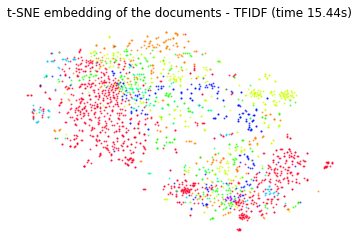

In [1566]:
%matplotlib inline

# GRAB OUTPUT
out = node_tensors.squeeze(0).detach().numpy()
print(f"{out.shape}")

# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(out)

plt.figure(figsize=(7,7))

plot_embedding(X_tsne,
               "t-SNE embedding of the documents - TFIDF (time %.2fs)" %
               (time() - t0))
plt.axis('off')
plt.show()

(2247, 64)
Computing t-SNE embedding


<Figure size 504x504 with 0 Axes>

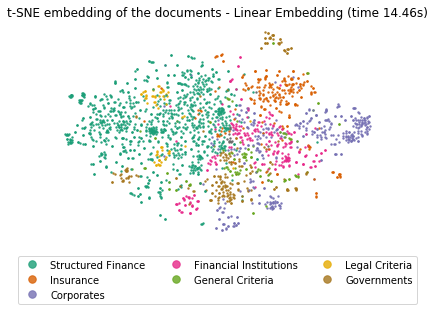

In [1724]:
%matplotlib inline

# GRAB OUTPUT
model.eval()
with torch.no_grad():
    out = model.gnet.emb(node_tensors)

out = out.squeeze(0).detach().numpy()
print(f"{out.shape}")

# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(out)

plt.figure(figsize=(7,7))

plot_embedding(X_tsne,
               "t-SNE embedding of the documents - Linear Embedding (time %.2fs)" %
               (time() - t0))
plt.axis('off')
plt.show()

In [1686]:
model = torch.load('lp_model_full_hidden_15_hidden_2.pkl')

(2247, 64)
Computing t-SNE embedding


<Figure size 1800x1080 with 0 Axes>

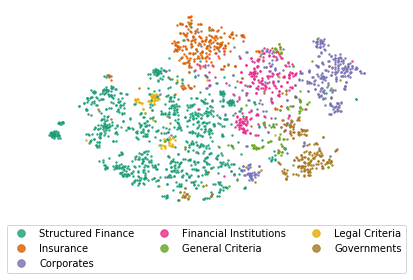

In [1801]:
%matplotlib inline

model = torch.load('lp_model_full_hidden_15_hidden_2.pkl')

# GRAB OUTPUT
model.eval()
with torch.no_grad():
    out, g_attn = model.gnet(node_tensors, None, adj_matrix, True)
    out = model.dot.linear(out)
    
out = out.squeeze(0).detach().numpy()
print(f"{out.shape}")

# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(out)

plt.figure(figsize=(25, 15))

plot_embedding(X_tsne,
               None)
plt.axis('off')
# plt.legend()
plt.tight_layout()

# plt.savefig('bilinear_embedding_legend.png', dpi=300)

plt.show()

In [358]:
print(label_to_class[21])

Corporates|Industrials


In [277]:

link_validation_set

{0: [710, 1667, 1894, 2116, 2139, 2180],
 1: [1545, 2182],
 2: [1894, 2209],
 3: [1894, 1936, 1951, 2065, 2212],
 4: [1020],
 8: [2016],
 9: [1223],
 19: [21, 1482, 1483, 1655],
 21: [19, 1198],
 31: [1421],
 32: [1877],
 39: [1236],
 42: [457],
 48: [883],
 54: [621, 626, 1039],
 60: [1624],
 68: [570],
 69: [1739],
 72: [2196],
 73: [621, 624, 1039],
 76: [400, 490, 1667, 1893, 1957, 2116],
 79: [400, 1786, 1859, 2196, 2220],
 80: [1018],
 82: [1878],
 85: [1037],
 96: [517, 1236],
 100: [55, 258],
 105: [1687],
 114: [187],
 120: [2, 1893, 1894, 1999, 2209],
 121: [1198, 1482],
 123: [1386],
 138: [1878],
 139: [69],
 141: [1357],
 142: [1453],
 146: [1024],
 150: [1236],
 152: [580],
 153: [457],
 155: [925],
 157: [1718],
 158: [1195],
 159: [1195],
 161: [1482, 1633],
 162: [2029, 2089, 2092, 2147],
 171: [315, 1823],
 176: [1191],
 180: [746],
 188: [2139],
 189: [1006],
 190: [317],
 191: [615, 720],
 192: [79, 400],
 199: [920],
 203: [2065],
 204: [209, 213, 663, 699],
 206: 

In [1589]:
val_set

{763: [225, 1005, 1039, 1164, 2001],
 2227: [1659, 1671, 2188, 2192],
 805: [235, 769, 1226, 1560, 1567],
 2011: [356,
  400,
  811,
  1632,
  1680,
  1688,
  1708,
  1753,
  1767,
  1768,
  1783,
  1785,
  1792,
  1838,
  1875,
  1876,
  1934,
  1958,
  2012,
  2051,
  2098,
  2131,
  2138,
  2140,
  2183,
  2217,
  2220,
  2221],
 2074: [400, 1888, 1889, 2005, 2029, 2089, 2092],
 1324: [1, 400, 710, 1195, 1561, 1893, 2181, 2182, 2188],
 65: [293],
 1192: [1186, 1190, 1193],
 1366: [363, 652, 1350, 1362, 1364, 1856],
 912: [756],
 2077: [400, 598, 880, 1162, 1570, 1943, 2076, 2117, 2194, 2242],
 2139: [1655, 1910, 1911, 1961, 2057, 2091, 2134],
 491: [400, 673, 857, 1608, 1975, 2121],
 560: [555, 1697, 1758],
 645: [677, 848, 908],
 444: [703, 1767, 1773, 1789, 2221],
 682: [819],
 2164: [490,
  724,
  773,
  775,
  1190,
  1191,
  1198,
  1632,
  1633,
  1667,
  1668,
  1753,
  1803,
  1934,
  2009,
  2048,
  2116,
  2150],
 1721: [291,
  356,
  400,
  490,
  715,
  745,
  747,
  975

In [1611]:
mid = 1622

best_model.eval()
with torch.no_grad():
    embeddings, d_output = best_model(node_tensors, node_tensors, 
                               node_mask=None, adj_matrix=fake_adj_matrix, return_weights=False)

    
target_row = embeddings[:, mid, :].squeeze(0) # V
scores = sorted([(i, v.item()) for i, v in enumerate(target_row)], key=lambda x:x[1], reverse=True)
title_d = [(pid_to_title[index_to_pid[pid]], dist, pid in [mid] + val_set[mid]) for (pid, dist) in  scores]

In [1796]:
pid_to_title[index_to_pid[24]]

'Distressed Debt CDOs: Spinning Straw Into Gold'

In [1795]:
index_to_pid[24]

18056053

In [1613]:
title_d

[('Assessing Asset-Liability Mismatch Risk In Covered Bonds: Revised Methodology And Assumptions For Target Asset Spreads',
  12.06282901763916,
  True),
 ('Principles Of Credit Ratings', 8.748146057128906, True),
 ('Criteria For Rating Swedish Covered Bonds', 6.095554828643799, True),
 ('Covered Bond Ratings Framework: Methodology And Assumptions',
  5.408641338348389,
  False),
 ('Methodology For Assessing Mortgage Insurance And Similar Guarantees And Supports In Structured And Public Sector Finance And Covered Bonds',
  5.348014831542969,
  False),
 ('Revised Methodology And Assumptions For Assessing Asset-Liability Mismatch Risk In Covered Bonds',
  5.330114364624023,
  True),
 ('Rating Pfandbriefe--The Analytical Perspective', 5.2038044929504395, False),
 ('Covered Bond Ratings Framework: Methodology And Assumptions',
  4.990721702575684,
  False),
 ('Australian RMBS Rating Methodology And Assumptions',
  4.84270715713501,
  False),
 ('Updated Cash Flow Assumptions For Modeling Ce

In [317]:
mid = 301

# GRAB OUTPUT
model.eval()
with torch.no_grad():
    node_embed = model.gnet.emb(node_tensors)
    out, g_attn = model.gnet.gnet(node_embed, adj_matrix, True)

# collect distances
corpus = out.squeeze(0)
target = out[:, mid, :].expand_as(corpus)
distances = sorted([(i, v.item()) for i, v in enumerate(F.cosine_similarity(target, corpus))], key= lambda x : x[1], reverse=True)

title_d = [(pid_to_title[index_to_pid[pid]], dist) for (pid, dist) in  distances]


In [318]:
pid_to_title[index_to_pid[mid]]

'Request For Comment: CDOs And Pooled TOBs Backed By U.S. Municipal Debt; Methodology And Assumptions'

In [319]:
[(index_to_pid[i], pid_to_title[index_to_pid[i]]) for i in link_validation_set[mid]]

[(18145849,
  'Global Cash Flow And Synthetic CDO Criteria: Rating Municipal CDOs'),
 (18224121, 'Principles Of Credit Ratings'),
 (18254546, 'Methodology: Credit Stability Criteria'),
 (18270307,
  'Advance Notice Of Proposed Criteria Change: Rating Municipal CDOs'),
 (18290300,
  'Application Of Supplemental Tests For Rating Global Corporate Cash Flow And Synthetic CDOs'),
 (18340059, 'Secondary Market Derivative Products'),
 (18469717, 'Long-Term Municipal Pools'),
 (18570416,
  'Revising U.S. Municipal CDO Modeling Assumptions In CDO Evaluator Version 3.3')]

In [320]:
titles_checked = [index_to_pid[i] for i in link_validation_set[mid]] + [index_to_pid[mid]]

title_d = [(index_to_pid[pid], pid_to_title[index_to_pid[pid]], dist, (index_to_pid[pid] in titles_checked)) for (pid, dist) in  distances]

# titles_checked

In [321]:
index_to_pid[mid]

18178357

In [1793]:
# content.to_dict('records')[0]

In [322]:
title_d[:10]

[(18178357,
  'Request For Comment: CDOs And Pooled TOBs Backed By U.S. Municipal Debt; Methodology And Assumptions',
  1.0,
  True),
 (18181191,
  'Advance Notice Of Proposed Criteria Change: Methodology And Assumptions For Rating European Commercial Mortgage-Backed Securities',
  0.7938840389251709,
  False),
 (18261143,
  'Updated Methodology And Assumptions For Rating Global Credit Derivative Product Companies',
  0.7563871741294861,
  False),
 (18277792,
  'Summary And Highlights Of Proposed Changes To Our Global Rating Methodology For Corporate Cash Flow And Synthetic CDOs',
  0.7514479160308838,
  False),
 (25661658,
  'Request For Comment: Methodology And Assumptions For U.S. Small Business Loan-Backed Securitizations',
  0.7344961762428284,
  False),
 (18145849,
  'Global Cash Flow And Synthetic CDO Criteria: Rating Municipal CDOs',
  0.729218065738678,
  True),
 (28699519,
  'Update To Global Methodologies And Assumptions For Corporate Cash Flow And Synthetic CDOs',
  0.72561

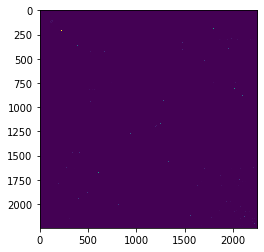

In [994]:
%matplotlib inline
# MHA ANALYSIS

idx = 1

# GRAB OUTPUT
model.eval()
with torch.no_grad():
    node_embed = model.gnet.emb(node_tensors)
    out, g_attn = model.gnet.gnet(node_embed, adj_matrix, True)
    

# print(g_attn[idx]['mha'])
plt.imshow(g_attn[idx]['mha'].mean(1).squeeze(0).detach().numpy())
plt.show()

# print(g_attn[idx]['mha'].max(dim=-2)[0])
# print(g_attn[idx]['mha'].mean(dim=-2))

tensor([[[0.9095, 0.0905],
         [0.8604, 0.1396],
         [0.9213, 0.0787],
         ...,
         [0.9616, 0.0384],
         [0.4460, 0.5540],
         [0.9547, 0.0453]]])


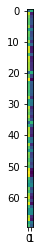

tensor([[0.9912, 0.8079]])
tensor([[0.8380, 0.1620]])


In [1727]:
%matplotlib inline
# RESIDUAL ANALYSIS

idx = 0

# GRAB OUTPUT
model.eval()
with torch.no_grad():
    node_embed = model.gnet.emb(node_tensors)
    out, g_attn = model.gnet.gnet(node_embed, adj_matrix, True)
    

print(g_attn[idx]['res'])
plt.imshow(g_attn[idx]['res'].squeeze(0).detach().numpy()[20:90, :])
plt.show()

print(g_attn[idx]['res'].max(dim=-2)[0])
print(g_attn[idx]['res'].mean(dim=-2))

tensor([[[0.9695, 0.0305],
         [0.9283, 0.0717],
         [0.9475, 0.0525],
         ...,
         [0.9356, 0.0644],
         [0.9705, 0.0295],
         [0.9835, 0.0165]]])


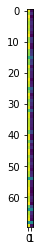

tensor([[0.9958, 0.7218]])
tensor([[0.9208, 0.0792]])


In [1728]:
%matplotlib inline
# RESIDUAL ANALYSIS

idx = 1

# GRAB OUTPUT
model.eval()
with torch.no_grad():
    node_embed = model.gnet.emb(node_tensors)
    out, g_attn = model.gnet.gnet(node_embed, adj_matrix, True)
    

print(g_attn[idx]['res'])
plt.imshow(g_attn[idx]['res'].squeeze(0).detach().numpy()[20:90, :])
plt.show()

print(g_attn[idx]['res'].max(dim=-2)[0])
print(g_attn[idx]['res'].mean(dim=-2))